# Public Cloud Marketplace Competitive Analysis and Sales Prediction

# 1. Introduction

In the domestic market, Aliyun, Tencent Cloud, and Huawei Cloud have established versatile marketplaces that offer a wide range of enterprise-level solutions, including infrastructure, security, AI, IoT, and more.

This project aims to analyze the competitive capabilities of these cloud service providers in terms of product types, pricing, delivery methods, and other factors. Additionally, it seeks to predict sales based on these features.

Through this analysis, we aim to gain clear insights into the current status and future trends of the public cloud marketplace. Furthermore, we will provide recommendations to companies seeking to procure cloud services.

## 2. Overview

This project is conducted through the following steps:

1. Data Collection and Preprocessing
2. Data Analysis and Visualization
3. Data Modeling and Prediction


## 2.1 Data Collection and Preprocessing

In Data Collection and Preprocessing, our approach includes:

1. Identifying the target cloud service providers: Aliyun, Tencent Cloud, Huawei Cloud, eSurfing Cloud, Kingsoft Cloud, and QingCloud.
2. Reviewing their websites' `robots.txt` files to verify permissions for web scraping.
3. Analyzing the structure and interconnections of their web pages to determine the relevant information and appropriate scraping techniques.
4. Developing Python scripts to scrape the websites and preprocess the collected data, addressing issues such as missing values, outliers, and data type inconsistencies.

*Note: This part is conducted by WU MEIHUI, LIU YAPING, and OU JINGZHEN.*

### 2.1.1 Kingsoft Cloud Data Collection and Preprocessing

Kingsoft Cloud Data Collection:

1. Accessed the product list page and scraped the product information.
2. Implemented pagination to scrape all available pages.
3. Saved the collected information to a CSV file.

Troubleshooting:

During data scraping, multiple tags were found in the tags field for each product. However, in the output results, multiple tags appeared in a single cell, making it difficult to distinguish between different tags. To address this issue, the code was adjusted as follows:

1. Split tags into separate columns: Used `find_elements` to scrape all `<span>` tags and dynamically set each tag as a separate column.
2. Ensured complete data scraping: Checked the number of scraped products in the loop, and if it was less than the target number, continued retrying.

In [ ]:

import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.edge.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Configure EdgeDriver
driver_path = 'D:\\CISC7201\\edgedriver_win64\\msedgedriver.exe'
service = Service(driver_path)
options = Options()
options.add_argument("--headless")  # Headless mode
options.add_argument("--disable-gpu")

# Launch browser
driver = webdriver.Edge(service=service, options=options)
driver.get("https://market.ksyun.com/list")

# Function to scrape product information
def get_product_info(driver):
    products = []
    try:
        # Get all products on the current page
        product_elements = driver.find_elements(By.XPATH, "/html/body/div[5]/div[3]/div[1]/div[2]/ul/li")
        for product in product_elements:
            try:
                # Extract product information
                title = product.find_element(By.XPATH, ".//div[3]/div[1]").text
                intro = product.find_element(By.XPATH, ".//div[3]/div[2]").text
                delivery_type = product.find_element(By.XPATH, ".//div[3]/div[3]").text
                company = product.find_element(By.XPATH, ".//div[3]/div[4]").text
                # Extract tags information
                # tags_elements = product.find_elements(By.XPATH, ".//div[3]/div[5]/span")
                # tags = [tag.text for tag in tags_elements]  # Extract all tag texts into a list
                price_number = product.find_element(By.XPATH, ".//div[4]/span[2]").text
                price_unit = product.find_element(By.XPATH, ".//div[4]/span[3]").text
                products.append({
                    "Title": title,
                    "Intro": intro,
                    "Delivery Type": delivery_type,
                    "Company": company,
                #    **{f"Tag {i+1}": tag for i, tag in enumerate(tags)},  # Split tags into columns
                    "Price Number": price_number,
                    "Price Unit": price_unit
                })
            except Exception as e:
                print(f"Failed to scrape a single product: {e}")
    except Exception as e:
        print(f"Failed to scrape the current page: {e}")
    return products

# Click the next page button
def click_next_page(driver):
    try:
        next_page_xpath = '/html/body/div[5]/div[3]/div[1]/div[2]/div[2]/a[9]'
        next_page_button = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.XPATH, next_page_xpath))
        )
        if "disabled" in next_page_button.getAttribute("class"):
            return False  # Reached the last page
        next_page_button.click()
        time.sleep(1)  # Wait for the page to load
        return True
    except Exception as e:
        print(f"Failed to turn the page or reached the last page: {e}")
        return False

# Scrape all pages
def scrape_all_pages(driver, max_pages=26, max_items=257):
    all_products = []
    page = 1
    while page <= max_pages:
        print(f"Scraping page {page}...")
        try:
            products = get_product_info(driver)
            all_products.extend(products)
            if len(all_products) >= max_items:
                print("Reached the target number of products, stopping scraping.")
                break
            if not click_next_page(driver):
                print("Reached the last page.")
                break
        except Exception as e:
            print(f"Failed to scrape page {page}: {e}")
        page += 1
    return all_products

# Save to CSV file
def save_to_csv(products, filename="products.csv"):
    try:
        df = pd.DataFrame(products)
        df.to_csv(filename, index=False, encoding="utf-8-sig")
        print(f"Data saved to {filename}")
    except Exception as e:
        print(f"Failed to save CSV file: {e}")

# Main program
try:
    start_time = time.time()
    all_products = scrape_all_pages(driver, max_pages=26, max_items=257)
    save_to_csv(all_products, "products.csv")
    end_time = time.time()
    print(f"Scraped {len(all_products)} product information, took {end_time - start_time:.2f} seconds")
finally:
    driver.quit()


Kingsoft Cloud Data Preprocessing:

- Data type processing: No processing needed.
- Outlier processing: No outliers found.
- Missing value processing: No missing values.

In [ ]:
import pandas as pd

df = pd.read_csv('kingsoft_product_info.csv')
print(df.info())

### 2.1.2 QingCloud Data Collection and Preprocessing

QingCloud Data Collection:

1. Accessed the homepage and navigated to the product list page by clicking the search button.
2. Scraped product information, including detailed category information for each product by visiting individual product detail pages.
3. Implemented pagination to scrape all available pages. To ensure continuity in case of disruptions, the current page number was recorded in a file.
4. Saved the collected information to a CSV file.

In [ ]:

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException
from concurrent.futures import ThreadPoolExecutor
import os
import csv
import time

url = "https://marketplace.qingcloud.com/"

def open_driver(url):
    global driver
    options = webdriver.ChromeOptions()
    options.add_experimental_option("detach", True)
    options.add_experimental_option('excludeSwitches', ['enable-logging']) # for ignore warning and error
    driver = webdriver.Chrome(options=options)
    driver.get(url)
    driver.maximize_window()
    return driver

def get_product_info(productitem):
    """extract product info from product item"""
    attempts = 0
    while attempts < 3:
        try:
            title = productitem.find_element(By.CLASS_NAME, 'ProductItem_content__3ygs9').find_element(By.TAG_NAME, 'h1').text
            price = productitem.find_element(By.CLASS_NAME, 'ProductItem_priceTotal__3W54J').text.replace("\n", "").replace(" ", "") # remove space and newline
            company = productitem.find_element(By.CLASS_NAME, 'ProductItem_content__3ygs9').find_elements(By.TAG_NAME, 'p')[-1].text.replace("服务商：", "")
            deliverytype = productitem.find_element(By.CLASS_NAME, 'ProductItem_time__dfVBM').find_element(By.TAG_NAME, 'span').text.replace("交付方式：", "")
            publishtime = productitem.find_element(By.CLASS_NAME, 'ProductItem_time__dfVBM').find_element(By.TAG_NAME, 'em').text.replace("发布时间：", "")
            return title, price, company, deliverytype, publishtime
        except (StaleElementReferenceException, TimeoutException):
            attempts += 1
            print(f"Error occurred while fetching product info. Attempt {attempts}. Retrying...")
            time.sleep(2)  # retry after 2 seconds
    return "", "", "", "", ""

def get_classification_info(driver):
    """extract classification info from breadcrumb"""
    attempts = 0
    while attempts < 3:
        try:
            wait.until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, '.Breadcrumb_breadcrumb__1mqpv li')))
            breadcrumb_items = driver.find_elements(By.CSS_SELECTOR, '.Breadcrumb_breadcrumb__1mqpv li')
            firstclassification = breadcrumb_items[1].find_element(By.TAG_NAME, 'span').text if len(breadcrumb_items) > 1 else ""
            secondclassification = breadcrumb_items[2].find_element(By.TAG_NAME, 'span').text if len(breadcrumb_items) > 2 else ""
            return firstclassification, secondclassification
        except TimeoutException:
            attempts += 1
            print(f"Timeout while getting classification info. Attempt {attempts}. Retrying...")
            time.sleep(2)
    return "", ""

def fetch_product_info(driver, productitem):
    """extract product info from product item and open product detail page to get classification info"""
    attempts = 0
    while attempts < 3:
        try:
            title, price, company, deliverytype, publishtime = get_product_info(productitem)

            # open product detail page in new tab
            product_link = productitem.get_attribute('href')
            driver.execute_script("window.open(arguments[0], '_blank');", product_link)
            driver.switch_to.window(driver.window_handles[-1])  # switch to new tab

            # get classification info
            firstclassification, secondclassification = get_classification_info(driver)

            driver.close()  # close the tab
            driver.switch_to.window(driver.window_handles[0])  # switch back to main tab

            return (title, price, company, deliverytype, publishtime, firstclassification, secondclassification)
        except Exception as e:
            attempts += 1
            print(f"Error fetching product info: {e}. Attempt {attempts}. Retrying...")
            time.sleep(2)
    return "", "", "", "", "", "", ""

# read current page from file
current_page_file = 'qingcloud_current_page.txt'

def get_current_page():
    """read current page from file"""
    if os.path.exists(current_page_file):
        with open(current_page_file, 'r') as file:
            return int(file.read().strip())
    return 1  # default page

def save_current_page(page):
    """save current page to file"""
    with open(current_page_file, 'w') as file:
        file.write(str(page))

def get_info(driver):
    titles, prices, companies, deliverytypes, publishtimes, firstclassifications, secondclassifications = [], [], [], [], [], [], []

    with open('qingcloud_product_info.csv', mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        if os.stat('product_product_info.csv').st_size == 0:  # if file is empty, write header
            writer.writerow(['Title', 'Price', 'Company', 'Delivery Type', 'Publish Time', 'First Classification', 'Second Classification'])

        current_page = get_current_page()

        # skip to the current page
        for _ in range(current_page - 1):  # skip all pages before the current page
            print(f"skipping page {_ + 1}...")
            try:
                next_button = wait.until(EC.element_to_be_clickable((By.CLASS_NAME, 'Pagination_pagination__wVSmi'))).find_element(By.TAG_NAME, 'ul').find_elements(By.TAG_NAME, 'li')[-1] # find the last li
                next_button.click()
                time.sleep(2)  # wait for page to load
            except Exception as e:
                print(f"Error navigating to next page: {e}")
                return  # if can't navigate to the current page, return

        while True:
            print(f"Scraping page {current_page}...")
            productitems = wait.until(EC.visibility_of_all_elements_located((By.CLASS_NAME, 'ProductItem_product-item__2OCnj')))
            
            for index in range(len(productitems)):
                attempts = 0
                while attempts < 3:  # try 3 times to get product info
                    try:
                        productitem = productitems[index]  # retrieve product item
                        result = fetch_product_info(driver, productitem)
                        if result:
                            titles.append(result[0])
                            prices.append(result[1])
                            companies.append(result[2])
                            deliverytypes.append(result[3])
                            publishtimes.append(result[4])
                            firstclassifications.append(result[5])
                            secondclassifications.append(result[6])
                            writer.writerow(result)
                            file.flush()  # be sure to flush the file to write the data
                            break  # break the loop if product info is successfully fetched
                    except (StaleElementReferenceException, TimeoutException):
                        attempts += 1
                        print(f"StaleElementReferenceException for product index {index}, attempt {attempts}. Retrying...")
                        productitems = wait.until(EC.visibility_of_all_elements_located((By.CLASS_NAME, 'ProductItem_product-item__2OCnj')))
                        continue  # continue to next attempt if exception occurs

            # navigate to next page
            try:
                next_button = wait.until(EC.element_to_be_clickable((By.CLASS_NAME, 'Pagination_pagination__wVSmi'))).find_element(By.TAG_NAME, 'ul').find_elements(By.TAG_NAME, 'li')[-1]
                if "disabled" in next_button.get_attribute("class"):
                    print("No more pages to navigate.")
                    break
                next_button.click()
                current_page += 1  # increment current page
                save_current_page(current_page)  # save current page to file
                time.sleep(2)  # wait for page to load
            except Exception as e:
                print(f"Error navigating to next page: {e}")
                break

    print("Scraping completed.")
# open driver
driver = open_driver(url)
global wait
wait = WebDriverWait(driver, 10)

# click on search button
search_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="__next"]/div/div[2]/div/div[2]/div')))
search_button.click()

# get product info
get_info(driver)

# close driver
driver.quit()


QingCloud Data Preprocessing:

- Data type processing: Converted `Publish Time` to datetime format.
- Outlier processing: No outliers found.
- Missing value processing: Manually filled missing data due to the small amount of missing values.

In [ ]:
import pandas as pd

# read qingcloud_product_info.csv
df = pd.read_csv('青云/qingcloud_product_info.csv')
print(df.info())

# copy the data to a new csv file
df.to_csv('qingcloud_product_info_processing.csv', index=False, encoding='utf-8-sig')

# read qingcloud_product_info_process.csv
df_process = pd.read_csv('qingcloud_product_info_processing.csv')

# convert Publish Time to datetime format
df_process['Publish Time'] = pd.to_datetime(df_process['Publish Time'])

# print nan values
print(df_process.isnull().T.any()) # mannually fill nan values

# print info
print(df_process.info())


### 2.1.3 Tencent Cloud Data Collection and Preprocessing

Tencent Cloud Data Collection:

1. Accessed the product list page and scraped the product information.
2. Implemented pagination to scrape all available pages. To ensure continuity in case of disruptions, the current page number is recorded in a file.
3. Saved the collected information to a CSV file.

Troubleshooting:

1. **Hidden Data**: Some information (e.g., publish time, sales type) is embedded in the HTML. Initially, a request script was used to extract it, but only the homepage product information is directly in the HTML. Other pages require API requests, which have numerous parameters and limited openness. For details, refer to [Tencent Cloud API Documentation](https://cloud.tencent.com/document/product/306/57455).
2. **No Href Attribute**: Extracting product classification by entering the product detail page was considered. However, the href attribute for the product detail page was not included. Attempts to simulate clicking the product title using JavaScript returned "String does not support click operation".

After multiple attempts without success, we focused on extracting the product information directly presented on the page. This ensures a valuable and scalable data collection task, providing basic data support for subsequent analysis. Although the data may not be the most comprehensive, it still holds significant reference and analytical value.


In [ ]:
import csv
import time
import json
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException

url = "https://market.cloud.tencent.com/categories"

def open_driver(url):
    global driver
    options = webdriver.ChromeOptions()
    options.add_experimental_option("detach", True)
    options.add_experimental_option('excludeSwitches', ['enable-logging']) # for ignore warning and error
    driver = webdriver.Chrome(options=options)
    driver.get(url)
    driver.maximize_window()
    return driver

def get_product_info(mp_synopticCard):
    """extract product info from mp_synopticCard element"""
    attempts = 0
    while attempts < 3:
        try:
            title = mp_synopticCard.find_element(By.CLASS_NAME, "mp-synopticCard-block-title").text
            price = mp_synopticCard.find_element(By.CLASS_NAME, "mp-synopticCard-price").text
            score = mp_synopticCard.find_element(By.CLASS_NAME, "evaluation-score").text

            evaluation_tags = mp_synopticCard.find_elements(By.CLASS_NAME, "evaluation-tag")
            review = evaluation_tags[0].text.replace("评论", "") if len(evaluation_tags) > 0 else "0"
            purchase = evaluation_tags[1].text.replace("成交量", "") if len(evaluation_tags) > 1 else "0"

            company = mp_synopticCard.find_element(By.CLASS_NAME, "deliver-company-name").text

            delivery_tags = mp_synopticCard.find_elements(By.CLASS_NAME, "deliver-tag")
            deliverytype = delivery_tags[0].text.replace("交付方式：", "") if delivery_tags else "Unknown"

            return title, price, score, review, purchase, company, deliverytype

        except (StaleElementReferenceException, TimeoutException):
            attempts += 1
            print(f"Error occurred while fetching product info. Attempt {attempts}. Retrying...")
            time.sleep(2)  # retry after 2 seconds
    
    return "", "", "", "", "", "", ""

# read current page from file
current_page_file = 'tencent_current_page.txt'

def get_current_page():
    """read current page from file"""
    if os.path.exists(current_page_file):
        with open(current_page_file, 'r') as file:
            return int(file.read().strip())
    return 1  # default page 

def save_current_page(page):
    """save current page to file"""
    with open(current_page_file, 'w') as file:
        file.write(str(page))

def get_info(driver):
    titles, prices, scores, reviews, purchases, companies, deliverytypes = [], [], [], [], [], [], []

    with open('tencent_product_info.csv', mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        if os.stat('tencent_product_info.csv').st_size == 0:  # if file is empty, write header
            writer.writerow(['Title', 'Price', 'Score', 'Review', 'Purchase', 'Company', 'Delivery Type'])

        current_page = get_current_page()

        # skip to the current page
        for _ in range(current_page - 1):  # skip all pages before the current page
            print(f"skipping page {_ + 1}...")
            try:
                next_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//div[contains(@class, "mp-pagination__btn mp-pagination__btn--prev") and normalize-space(text())="下一页"]'))) # find next page button
                next_button.click()
                time.sleep(2)  # wait for page to load
            except Exception as e:
                print(f"Error navigating to next page: {e}")
                return  # if can't navigate to the current page, return

        while True:
            print(f"Scraping page {current_page}...")
            mp_synopticCards = wait.until(EC.visibility_of_all_elements_located((By.CLASS_NAME, 'mp-synopticCard')))
                
            for index in range(len(mp_synopticCards)):
                attempts = 0
                while attempts < 3:  # try 3 times to get product info
                    try:
                        mp_synopticCard = mp_synopticCards[index]  # get the product item
                        result = get_product_info(mp_synopticCard)
                        if result:
                            titles += [result[0]]
                            prices += [result[1]]
                            scores += [result[2]]
                            reviews += [result[3]]
                            purchases += [result[4]]
                            companies += [result[5]]
                            deliverytypes += [result[6]]
                            writer.writerow(result)
                            file.flush()  # be sure to flush the file to write immediately
                            break  # break the loop if product info is successfully fetched
                    except (StaleElementReferenceException, TimeoutException):
                        attempts += 1
                        print(f"StaleElementReferenceException for product index {index}, attempt {attempts}. Retrying...")
                        productitems = wait.until(EC.visibility_of_all_elements_located((By.CLASS_NAME, 'ProductItem_product-item__2OCnj')))
                        continue  # continue to the next attempt if error occurs

            # navigate to the next page
            try:
                next_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//div[contains(@class, "mp-pagination__btn mp-pagination__btn--prev") and normalize-space(text())="下一页"]'))) 
                if current_page >= 871: # 871 is the last page
                    print("Last page reached.")
                    break
                next_button.click()
                current_page += 1  # increment page number
                save_current_page(current_page)  # save current page to file
                time.sleep(2)  # wait for page to load
            except Exception as e:
                print(f"Error navigating to next page: {e}")
                break

    print("Scraping completed.")
    
# open browser
driver = open_driver(url)
global wait
wait = WebDriverWait(driver, 10)

# get product info
get_info(driver)

# close browser
driver.quit()


Tencent Cloud Data Preprocessing:

- Data type processing: No processing needed.
- Outlier processing: No outliers found.
- Missing value processing: Manually filled the empty values based on domain knowledge.

In [ ]:
import pandas as pd

# read qingcloud_product_info.csv
df = pd.read_csv('腾讯/tencent_product_info.csv')
print(df.info())

# copy the data to a new csv file
df.to_csv('tencent_product_info_processing.csv', index=False, encoding='utf-8-sig')

# read qingcloud_product_info_process.csv
df_process = pd.read_csv('tencent_product_info_processing.csv')

# print nan values
print(df_process.isnull().T.any()) # mannually fill nan values

# print info
print(df_process.info())


### 2.1.4 Aliyun Data Collection and Preprocessing

Aliyun Data Collection:

1. Accessed the product list page and implemented pagination to scrape all available pages.
2. Sent HTTP requests to each page to extract product publish times and matched them with product names.
3. Saved the collected information to a CSV file.

Troubleshooting:

1. **Incomplete Data Retrieval**: Initially, only the first product on each page was retrieved. This was resolved by switching from CSS and XPATH methods to the element_script method based on the page's JavaScript structure.
2. **Hidden Data**: The product publish time was not directly available on the page. We used BeautifulSoup to send HTTP requests, parse the HTML structure, and extract the publish time, matching it with the product name.


In [ ]:
%pip install beautifulsoup4 requests
import requests
import pandas as pd
from datetime import datetime
import time
import random
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.expected_conditions import *

import time
import csv
import random
import requests
import pandas as pd
from datetime import datetime
import logging

logging.basicConfig(level=logging.INFO)

url = 'https://market.aliyun.com/products/?spm=5176.730005.filter.56956004&page=1&k=&scene=market'

def open_driver(url):
    options = webdriver.EdgeOptions()
    options.add_experimental_option('excludeSwitches', ['enable-logging'])  # Ignore warnings and errors

    # Specify the path of EdgeDriver
    service = Service(executable_path=r"D:\Edge Webdriver\msedgedriver.exe")  # Change to your EdgeDriver path

    # Initialize Edge WebDriver with the specified Service
    driver = webdriver.Edge(service=service, options=options)
    driver.get(url)
    driver.implicitly_wait(10)  # Set implicit wait time
    driver.maximize_window()
    return driver

def gain_datas_ali_js(driver):
    # Use JavaScript to get data
    product_elements = driver.execute_script("""
        const productElements = document.querySelectorAll('.mk-card.vertical');
        const productData = [];
        for (const product of productElements) {
            const productName = product.querySelector('.mk-card-head-info-title a')?.textContent || 'N/A';
            const category = [...product.querySelectorAll('.commodity-tag .market-tag .market-tag-body')].map(tag => tag.textContent).join(', ') || 'N/A';
            const priceContainer = product.querySelector('.mk-card-buy-price-main');
            const priceValue = priceContainer?.querySelector('span')?.textContent || 'N/A';
            const priceUnit = priceContainer?.querySelector('i')?.textContent || '';
            const price = `${priceValue}${priceUnit}`;
            const productScoreElement = product.querySelector('.feature-data-info span:nth-child(1)');
            const productScore = productScoreElement?.textContent.replace('\\ue6ad', '') || 'N/A';
            const responseTimeElement = product.querySelector('.feature-data-info span:nth-child(2)');
            const responseTime = responseTimeElement?.textContent?.replace('\\ue6af', '').trim() || 'N/A';
            const slaElement = product.querySelector('.feature-data-info span:nth-child(3)');
            const sla = slaElement?.textContent?.replace('\\ue6ae', '').trim() || 'N/A';

            // Find all mk-card-property-item elements
            const propertyItems = product.querySelectorAll('.mk-card-property-item');
            let tradeCount = 'N/A';
            let reviewScore = 'N/A';
            let reviewCount = 'N/A';
            let deliveryMode = 'N/A';
            let deliveryTime = 'N/A';

            propertyItems.forEach(item => {
                const label = item.querySelector('label')?.textContent || '';
                if (label.includes('成交')) {
                    tradeCount = item.querySelector('span')?.textContent.split()[0] || 'N/A';
                } else if (label.includes('评论')) {
                    const texts = item.textContent.split(/[\\s\\ue678（）]+/);
                    reviewScore = texts[0] || 'N/A';
                    reviewCount = texts[1] || 'N/A';
                } else if (label.includes('交付方式')) {
                    deliveryMode = item.textContent.split(':')[0]?.trim() || 'N/A';
                } else if (label.includes('交付时间')) {
                    deliveryTime = item.textContent.split(':')[0]?.trim() || 'N/A';
                }
            });

            productData.push({
                'Product Name': productName,
                'Transaction Count': tradeCount,
                'Rating Score': reviewScore,
                'Rating Count': reviewCount,
                'Product Score': productScore,
                'Response Time': responseTime,
                'SLA': sla,
                'Price': price,
                'Category': category,
                'Delivery Mode': deliveryMode,
                'Delivery Time': deliveryTime
            });
        }
        return productData;
    """)

    # Add data to the list
    product_data = []
    for element in product_elements:
        # Clean the data
        element['Product Score'] = element['Product Score'].replace('\\ue6ad', '')
        element['Response Time'] = element['Response Time'].replace('\\ue6af', '')
        element['SLA'] = element['SLA'].replace('\\ue6ae', '')

        # Split Rating Score and Rating Count correctly
        rating_texts = element['Rating Score'].split()
        if len(rating_texts) > 1:
            element['Rating Count'] = rating_texts[1]
            element['Rating Score'] = rating_texts[0].replace('评论：', '')

        product_data.append(element)

    return product_data

def go_to_next_page(driver):
    try:
        next_button = driver.find_element(By.XPATH, "//button[contains(@aria-label, 'Next Page')]")
        next_button.click()
        time.sleep(random.uniform(15, 25))  # Stay on each page for a random time between 15 to 25 seconds
    except Exception as e:
        logging.error(f"Error clicking the next page button: {e}")
        return False
    return True

def t1():
    driver = open_driver(url)

    all_product_data = []

    for page in range(1, 334):
        logging.debug(f"Scraping data from page {page}...")

        # Wait for the page to load
        try:
            wait = WebDriverWait(driver, 10)
            wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, '.market-commodity-list')))
            logging.debug("Page loaded successfully.")
        except Exception as e:
            logging.error(f"Error waiting for the page to load: {e}")
            break

        # Get data from the current page
        page_data = gain_datas_ali_js(driver)
        all_product_data.extend(page_data)

        # Go to the next page
        if not go_to_next_page(driver):
            break

        # Simulate user behavior
        time.sleep(random.uniform(5, 10))  # Random wait for 5 to 10 seconds

    # Close the browser
    driver.quit()

    # Print the obtained product data
    for product in all_product_data:
        print(product)

    # Save to CSV file
    csv_file = 'product_data.csv'
    csv_columns = ["Product Name", "Transaction Count", "Rating Score", "Rating Count", "Product Score",
                   "Response Time", "SLA", "Price", "Category", "Launch Time", "Delivery Mode", "Delivery Time"]

    try:
        with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=csv_columns)
            writer.writeheader()
            for product in all_product_data:
                writer.writerow(product)
        logging.debug(f"Data successfully saved to {csv_file}")
    except IOError as e:
        logging.error(f"Error saving data to CSV file: {e}")

# Ensure open_driver and url variables are defined
t1()

# Function to get timestamp data
def get_timestamp_data(max_pages=334):
    timestamp_data = {}
    page = 1
    while page <= max_pages:
        url = f"https://market.aliyun.com/api/ajax/product/queryProducts.json?scene=market&page={page}&pageIndex={page}&pageSize=15&keywords="
        response = requests.get(url)

        # Check response status code
        if response.status_code != 200:
            print(f"Request failed, status code: {response.status_code}")
            break

        # Check if response content is empty
        if not response.content:
            print("Response content is empty")
            break

        try:
            data = response.json()
        except ValueError as e:
            print(f"JSON decode error: {e}")
            print("Response content:", response.content)
            break

        # Check if 'products' key exists in response data
        if 'result' not in data or 'products' not in data['result']:
            break

        products = data['result']['products']
        if not products:
            break

        for product in products:
            create_on = product.get('createOn')
            if create_on:
                readable_time = datetime.fromtimestamp(create_on / 1000).strftime('%Y-%m-%d %H:%M:%S')
                timestamp_data[product['name']] = readable_time

        page += 1
        time.sleep(random.uniform(5, 10))  # Random wait for 5 to 10 seconds

    return timestamp_data

# Function to add timestamp data to existing CSV file
def add_timestamp_to_csv(csv_file, output_file, max_pages=334):
    # Read the existing CSV file
    df = pd.read_csv(csv_file)

    # Get timestamp data
    timestamp_data = get_timestamp_data(max_pages)

    # Add timestamp data to DataFrame
    df['Created On'] = df['Product Name'].map(timestamp_data)

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_file, index=False)
    print(f"Timestamp data successfully added and saved as a new CSV file: {output_file}")

# Example usage
csv_file = '/content/product_data (1).csv'  # Existing CSV file
output_file = 'updated_product_data.csv'  # New CSV file
add_timestamp_to_csv(csv_file, output_file, max_pages=334)

Aliyun Data Preprocessing:

- **Data Type Processing**: The fields `Transaction Count`, `Rating Score`, `Rating Count`, `Product Score`, `Response Time`, `SLA`, and `Price` should be numeric. Currently, they are text due to the presence of units. We will remove these units and convert the fields to numeric data. Additionally, `Create On` and `Delivery Time` will be converted to date data.
- **Missing Value Processing**: 
    - The `Launch Time` column had all missing values, and we found that this data was saved in the `Delivery Time` column. Therefore, we deleted the `Launch Time` column.
    - `Rating Count` and `Product Score` had some missing values. The missing `Rating Count` fields corresponded to `Rating Score` of 0, indicating no comments on the product page, so we replaced the missing values with 0. For `Product Score`, there was no relevant data on the page, and it was not a technical omission. We tried filling the missing values with the median by delivery type, but this method was not accurate. Since we had a lot of existing data, we kept this column and created a new column `Product Score Missing` with 0 indicating missing and 1 indicating present.
    - The `Price` column had 29 missing values. Except for the product named "合乐-定制数据服务" which had a negotiable price, the rest were free to open and calculated on a per-use basis. Therefore, we filled the missing values with 0.1 based on other similar products on the website.
    - For fields such as `Response Time`, `SLA`, `Create On`, and `Delivery Time`, which were provided by the website backend and less affected by users, we did not process the missing values.
- **Outlier Processing**: There were some outliers in `Product Score`, `Response Time`, and `SLA` due to data scraping errors, so we directly deleted these outliers.


In [ ]:
import pandas as pd

# Read data
df = pd.read_csv('阿里/ali_data.csv')

# View basic information about the data
print(df.info())

# Copy the data to a new CSV file
df.to_csv('cleaned_ali_data.csv', index=False, encoding='utf-8-sig')

# Read the cleaned data
df_process = pd.read_csv('cleaned_ali_data.csv')

# Function to remove units
def remove_units(value, unit):
    if pd.isna(value):
        return value
    if isinstance(value, str):
        return value.replace(unit, '')
    return value

# Remove units from columns
df['Rating Score'] = df['Rating Score'].apply(lambda x: remove_units(x, '评论：'))
df['Rating Count'] = df['Rating Count'].apply(lambda x: remove_units(x, '条'))

# Process Response Time and SLA to keep specific formats
df['Response Time'] = df['Response Time'].str.extract(r'(\d+ms)')[0]  # Keep data containing ms
df['SLA'] = df['SLA'].str.extract(r'(\d+%)')[0]  # Keep data containing %

# Remove units from other columns
df['Delivery Mode'] = df['Delivery Mode'].str.replace('交付方式：', '')
df['Delivery Time'] = df['Delivery Time'].str.replace('交付时间：', '').str.replace('天', '').str.replace('工作日', '')
df['Transaction Count'] = df['Transaction Count'].str.replace('小于', '').str.replace('单', '')
df['Price'] = df['Price'].str.replace('￥', '').str.replace('万', '')

# Remove time scale units from Created On column, keeping only the date
df['Created On'] = df['Created On'].apply(lambda x: str(x).split(' ')[0] if isinstance(x, str) else x)

# Add Product Score column, remove non-numeric data
df['Product Score'] = df['Product Score'].apply(lambda x: pd.to_numeric(x, errors='coerce') if isinstance(x, str) and not any(char.isalpha() for char in x) and not x.startswith('-') else None)

# Convert processed columns to numeric data
df['Transaction Count'] = pd.to_numeric(df['Transaction Count'], errors='coerce')
df['Rating Score'] = pd.to_numeric(df['Rating Score'], errors='coerce')
df['Rating Count'] = pd.to_numeric(df['Rating Count'], errors='coerce')
df['Response Time'] = df['Response Time'].str.replace('ms', '').astype(float)  # Remove ms suffix and convert to numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['SLA'] = df['SLA'].str.replace('%', '').astype(float)  # Remove % suffix and convert to numeric
df['Delivery Time'] = pd.to_numeric(df['Delivery Time'], errors='coerce')

# Convert Created On column to datetime format
df['Created On'] = pd.to_datetime(df['Created On'], errors='coerce')

# Drop Launch Time column
df.drop(columns=['Launch Time'], inplace=True)

# Create missing indicator variable
df['Product Score Missing'] = df['Product Score'].notna().astype(int)

# Replace missing values in Rating Count with 0
df['Rating Count'].fillna(0, inplace=True)
df['Price'] = df['Price'].fillna(0.1)  # Replace missing values in Price with 0.1

# View basic information about the processed data
print(df_process.info())


### 2.1.5 Huawei Cloud Data Collection and Preprocessing

Huawei Cloud Data Collection:

1. Accessed the product list page and scraped the product information.
2. Implemented pagination to scrape all available pages.
3. Saved the collected information to a CSV file.

Troubleshooting:

1. **Anti-scraping Mechanism**: Initially, we used the same element path selection method as for Aliyun Marketplace. However, Huawei Cloud's anti-scraping mechanisms prevented the use of the `element_script` method. We switched to using a combination of CSS and XPath for element location and data scraping.
2. **Page Structure Changes**: During scraping, the page switched to a mobile scroll mode, causing errors in element selection for page navigation. By adopting the page switching method from pre-mini-project-01, we successfully resolved this issue.


In [ ]:
import requests
import json
import time
import re
from datetime import datetime
from bs4 import BeautifulSoup
import csv
import logging
import random
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

url = 'https://marketplace.huaweicloud.com/search/?selectedListIndex=0'

# Function to scrape product information
def get_product_info(driver, csvfile):
    print("Starting to scrape product information...")
    try:
        product_elements = driver.find_elements(By.CSS_SELECTOR, ".show-product")
        
        for product in product_elements:
            product_data = {
                "Title": "n/a",
                "Categories": "n/a",
                "Intro": "n/a",
                "Merchant": "n/a",
                "Delivery Type": "n/a",
                "Transaction Number": "n/a",
                "Rating Count": "n/a",
                "Product Score": "n/a",
                "Price Number": "n/a",
                "Price Unit": "n/a",
                "Price Others": "n/a",
                "Success": False
            }

            # Attempt to scrape various information
            try:
                product_data["Title"] = product.find_element(By.CSS_SELECTOR, "h1.color_text_primary_dark a").text
                print(f"Title scraped successfully: {product_data['Title']}")
            except Exception:
                print("Failed to scrape title: n/a")

            try:
                product_data["Categories"] = [span.text for span in product.find_elements(By.CSS_SELECTOR, ".product-content .tag-list span")]
                print(f"Categories scraped successfully: {product_data['Categories']}")
            except Exception:
                print("Failed to scrape categories: n/a")

            try:
                intro_element = product.find_element(By.XPATH, ".//*[contains(@id, 'product-description')]")
                product_data["Intro"] = intro_element.text
                print(f"Intro scraped successfully: {product_data['Intro']}")
            except Exception:
                print("Failed to scrape intro: n/a")

            try:
                product_data["Merchant"] = product.find_element(By.CSS_SELECTOR, ".msg-line ul.merchant li a").text
                print(f"Merchant scraped successfully: {product_data['Merchant']}")
            except Exception:
                print("Failed to scrape merchant: n/a")

            try:
                product_data["Delivery Type"] = product.find_element(By.CSS_SELECTOR, ".payment-method .method-txt").text
                print(f"Delivery type scraped successfully: {product_data['Delivery Type']}")
            except Exception:
                print("Failed to scrape delivery type: n/a")

            try:
                product_data["Transaction Number"] = product.find_element(By.CSS_SELECTOR, ".other-line .mkp-volume").text
                print(f"Transaction number scraped successfully: {product_data['Transaction Number']}")
            except Exception:
                print("Failed to scrape transaction number: n/a")

            try:
                product_data["Rating Count"] = product.find_element(By.CSS_SELECTOR, ".other-line .mkp-comment").text
                print(f"Rating count scraped successfully: {product_data['Rating Count']}")
            except Exception:
                print("Failed to scrape rating count: n/a")

            try:
                product_data["Product Score"] = product.find_element(By.CSS_SELECTOR, ".mkp-comment-layout .mkp-score").text
                print(f"Product score scraped successfully: {product_data['Product Score']}")
            except Exception:
                print("Failed to scrape product score: n/a")

            try:
                price_element = product.find_element(By.XPATH, ".//span[contains(@class, 'product-price-number')]")
                product_data["Price Number"] = price_element.text.strip()
                product_data["Price Unit"] = product.find_element(By.CSS_SELECTOR, ".product-price .product-rmb").text
                product_data["Price Others"] = product.find_element(By.CSS_SELECTOR, ".product-finalUnit .result-cloudmarket-price-tips").text
                print(f"Price scraped successfully: {product_data['Price Number']} {product_data['Price Unit']} {product_data['Price Others']}")
            except Exception:
                print("Failed to scrape price: n/a")

            product_data["Success"] = True

            # Write current product data to CSV file
            pd.DataFrame([product_data]).to_csv(csvfile, mode='a', index=False, header=not csvfile.tell(), encoding='utf-8-sig')

    except Exception as e:
        print(f"Failed to scrape current page: {e}")

# Main program
if __name__ == "__main__":
    options = webdriver.ChromeOptions()
    options.add_argument("user-agent=Mozilla/5.0")
    driver = webdriver.Chrome(options=options)

    output_file = "products.csv"

    try:
        # Open CSV file
        with open(output_file, mode='w', encoding='utf-8-sig', newline='') as csvfile:
            # Write header
            pd.DataFrame(columns=[
                "Title", "Categories", "Intro", "Merchant", "Delivery Type", 
                "Transaction Number", "Rating Count", "Product Score", 
                "Price Number", "Price Unit", "Price Others", "Success"
            ]).to_csv(csvfile, index=False)

            driver.get('https://marketplace.huaweicloud.com/search/?selectedListIndex=0&pageNo=1')
            max_pages = 589  # Total number of pages
            current_page = 1

            while current_page <= max_pages:
                print(f"Loading page {current_page}...")
                WebDriverWait(driver, 20).until(
                    EC.visibility_of_element_located((By.CSS_SELECTOR, ".show-product"))
                )
                print("Page loaded.")

                get_product_info(driver, csvfile)  # Pass CSV file object

                # Pagination logic
                try:
                    active_page = driver.find_element(By.CSS_SELECTOR, "li.por-page-item.active")
                    next_page_element = active_page.find_element(By.XPATH, "following-sibling::li/a")
                    next_page_element.click()
                    current_page += 1
                    print(f"Going to next page: {current_page}")
                    time.sleep(2)
                except Exception as e:
                    print(f"Failed to paginate: {e}")
                    break

    finally:
        driver.quit()


Huawei Cloud Data Preprocessing:

- **Data Type Processing**: 
    - Convert `Product Score` to float and `Success` to boolean.
    - Remove text units from `Transaction Number`, `Rating Count`, and `Price Number` fields and convert them to numeric types.
- **Outlier Processing**: 
    - Remove the `Success` column as it is only used to check if the data was successfully scraped.
    - Delete rows where data scraping failed, indicated by `n/a` values in the columns.
- **Missing Value Processing**: 
    - For the `Delivery Type` column, manually fill the single missing value by searching and copying the relevant information.

In [ ]:
import pandas as pd

# Read data
df = pd.read_csv('华为/huawei_data.csv')

# View basic information about the data
print(df.info())

# Copy the data to a new CSV file
df.to_csv('cleaned_huawei_data.csv', index=False, encoding='utf-8-sig')

# Read the cleaned data
df_process = pd.read_csv('cleaned_huawei_data.csv')

# Drop the column with no actual meaning
df = df.drop(columns=['Success'])

# Process Transaction Number, remove prefix and suffix
df['Transaction Number'] = df['Transaction Number'].str.replace('成交：', '').str.replace('笔', '')

# Process Rating Count, remove prefix and suffix
df['Rating Count'] = df['Rating Count'].str.replace('评论：', '').str.replace('条', '')

# Process Price Number, remove currency symbol and comma
df['Price Number'] = df['Price Number'].str.replace('￥', '').str.replace(',', '')

# Convert to numeric type
df['Transaction Number'] = pd.to_numeric(df['Transaction Number'], errors='coerce')
df['Rating Count'] = pd.to_numeric(df['Rating Count'], errors='coerce')
df['Price Number'] = pd.to_numeric(df['Price Number'], errors='coerce')

# Drop rows where Title is "n/a"
df = df[df['Title'] != 'n/a']

# View basic information about the processed data
print(df_process.info())

### 2.1.6 eSurfing Cloud Data Collection and Preprocessing

eSurfing Cloud Data Collection:

1. Accessed the product list page and scraped the product information.
2. Implemented pagination to scrape all available pages.
3. Saved the collected information to a CSV file.

In [ ]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.expected_conditions import *
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException
from io import BytesIO  
from PIL import Image  
import base64 

import time
import json
import os
import csv
import random
import logging

logging.basicConfig(level=logging.INFO)

url = 'https://market.ctyun.cn/market/mallproductlist?'

def open_driver(url):  
    options = webdriver.EdgeOptions()  
    options.add_experimental_option('excludeSwitches', ['enable-logging'])  # Ignore warnings and errors  
    
    # Specify the path to EdgeDriver  
    service = Service(executable_path=r"D:\Edge Webdriver\msedgedriver.exe")  # Change to your EdgeDriver path  
    
    # Initialize Edge WebDriver with the specified Service  
    driver = webdriver.Edge(service=service, options=options)  
    driver.get(url)  
    driver.implicitly_wait(10)  # Set implicit wait time  
    driver.maximize_window()  
    return driver 
open_driver(url)

def gain_data_tianyi(driver):  
    # Use JavaScript to get data  
    product_elements = driver.execute_script("""  
        const productElements = document.querySelectorAll('.item-box');  
        const productData = [];  
        for (const product of productElements) {  
            const productName = product.querySelector('.title')?.textContent || 'N/A';  
            const category = [...product.querySelectorAll('.tag-item span')].map(tag => tag.textContent).join(', ') || 'N/A';  
            const description = product.querySelector('.content')?.textContent || 'N/A';  
            
            // Find all detail-item elements
            const detailItems = product.querySelectorAll('.detail-item');
            let provider = 'N/A';
            let deliveryMode = 'N/A';
            let salesRegion = 'N/A';

            detailItems.forEach(item => {
                const label = item.querySelector('.detail-label')?.textContent || '';
                if (label.includes('服务商')) {
                    provider = item.querySelector('.detail-value')?.textContent || 'N/A';
                } else if (label.includes('交付方式')) {
                    deliveryMode = item.querySelector('.detail-value')?.textContent || 'N/A';
                } else if (label.includes('销售区域')) {
                    salesRegion = item.querySelector('.detail-value, .detail-value-ellipsis2')?.textContent || 'N/A';
                }
            });

            const priceValue = product.querySelector('.price')?.textContent || 'N/A';
            const priceUnit = product.querySelector('.unit')?.textContent || '';
            const price = `${priceValue}${priceUnit}`;

            productData.push({  
                'Product Name': productName,  
                'Category': category,  
                'Description': description,  
                'Provider': provider,  
                'Delivery Mode': deliveryMode,  
                'Sales Region': salesRegion,  
                'Price': price
            });  
        }  
        return productData;  
    """)  

    # Add data to list
    product_data = []
    for element in product_elements:
        product_data.append(element)

    return product_data

def go_to_next_page(driver):
    try:
        next_button = driver.find_element(By.CLASS_NAME, "btn-next")

        next_button.click()
        time.sleep(random.uniform(15, 25))  # Stay on each page for a random time between 15 to 25 seconds
    except Exception as e:
        logging.error(f"Error clicking the next page button: {e}")
        return False
    return True
    # Click the next page button

def click_next_page(driver):
    try:
        next_page_xpath = '//*[@id="app"]/div[2]/div/div/div/div[2]/div[3]/div/div[2]/div/button[2]'
        next_page_button = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.XPATH, next_page_xpath))
        )
        if "disabled" in next_page_button.get_attribute("class"):
            return False  # Already on the last page
        next_page_button.click()
        time.sleep(1)  # Wait for the page to load
        return True
    except Exception as e:
        print(f"Failed to turn the page or already on the last page: {e}")
        return False

def click_next_page_1(driver):
    try:
        next_page_xpath = '//*[@id="app"]/div[2]/div/div/div/div[2]/div[3]/div/div[2]/div/button[2]'
        next_page_button = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.XPATH, next_page_xpath))
        )
        driver.execute_script("arguments[0].scrollIntoView(true);", next_page_button)
        driver.execute_script("arguments[0].click();", next_page_button)
        time.sleep(1)  # Wait for the page to load
        return True
    except Exception as e:
        print(f"Failed to turn the page or already on the last page: {e}")
        return False

def t1():
    driver = open_driver(url)
    
    all_product_data = []
    
    for page in range(1, 20):
        logging.debug(f"Scraping data from page {page}...")
        
        # Wait for the page to load
        try:
            wait = WebDriverWait(driver, 10)
            wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, '.list-box')))
            logging.debug("Page loaded successfully.")
        except Exception as e:
            logging.error(f"Error waiting for the page to load: {e}")
            break
        
        # Get data from the current page
        page_data = gain_data_tianyi(driver)
        all_product_data.extend(page_data)
        
        # Turn the page
        if not click_next_page(driver):
            break
        
        # Simulate user behavior
        time.sleep(random.uniform(5, 10))  # Random wait between 5 to 10 seconds

    # Close the browser
    driver.quit()

    # Print the obtained product data
    for product in all_product_data:
        print(product)

    # Save to CSV file
    csv_file = 'tianyi_data.csv'
    csv_columns = ["Product Name", "Category", "Description", "Provider", "Delivery Mode", "Sales Region", "Price"]

    try:
        with open(csv_file, mode='w', newline='', encoding='utf-8-sig') as file:
            writer = csv.DictWriter(file, fieldnames=csv_columns)
            writer.writeheader()
            for product in all_product_data:
                writer.writerow(product)
        logging.debug(f"Data successfully saved to {csv_file}")
    except IOError as e:
        logging.error(f"Error saving data to CSV file: {e}")

# Ensure open_driver and url variables are defined
t1()

eSurfing Cloud Data Preprocessing:

- **Data Type Processing**: The `Price` field should be a numeric field, but it is currently an object field due to the presence of units.
- **Outlier Processing**: No outliers were found.
- **Missing Value Processing**: Due to the small amount of missing data and the inability to find relevant product names on the webpage, we decided to delete the rows with missing data.


In [ ]:
import pandas as pd

# Read data
df = pd.read_csv('天翼/tianyi_data.csv')

# View basic information about the data
print(df.info())

## 2.2 Data Analysis and Visualization

In Data Analysis and Visualization, our approach includes:

1. Analyzing the differences in product type versatility and delivery method proportions among top-tier cloud service providers.
2. Comparing the pricing strategies between top-tier and second-tier cloud service providers.

*Note: This part is conducted by CHE YUHENG.*

### 2.2.1 Competitive Analysis Among Top-Tier Cloud Service Providers

Product Category Analysis:

1. Loaded Alibaba, Huawei, and Tencent datasets, focusing on key columns: product name, description, and category.
2. Pre-defined categories (e.g., authentication, security, database) with relevant keywords (e.g., "firewall", "SSL", "cloud migration").
3. Designed a function to categorize products based on keyword matches in titles and descriptions, labeling unmatched products as "Other."
4. Analyzed high-frequency words in the "Other" category and expanded keyword lists to improve classification accuracy.
5. Iteratively refined the classification process to reduce the "Other" category.
6. Created a grouped bar chart to visualize the distribution of products across categories in each dataset.

,Product Name,Category
0,身份实名认证-身份证实名认证-身份证实名-实名认证-身份证二要素-身份证实名认证-身份实名认...,认证类 (Authentication)
1,【数脉API】手机三要素-手机三要素-运营商实名认证-运营商三要素手机号校验查询-手机实名核...,认证类 (Authentication)
2,系统硬盘数据恢复 数据救援 格式化后数据恢复 删除delete数据库恢复 myd idb数据...,安全类 (Security)
3,消息推送（U-Push Pro）,短信/通知类 (Messaging/Notifications)
4,云·企业官网（SaaS系统）,安全类 (Security)
...,...,...
4995,Quick Service 智能辅助,其他 (Others)
4996,云器Lakehouse,安全类 (Security)
4997,阿里云服务器操作系统 x86_64,安全类 (Security)
4998,风险违禁词检测,其他 (Others)


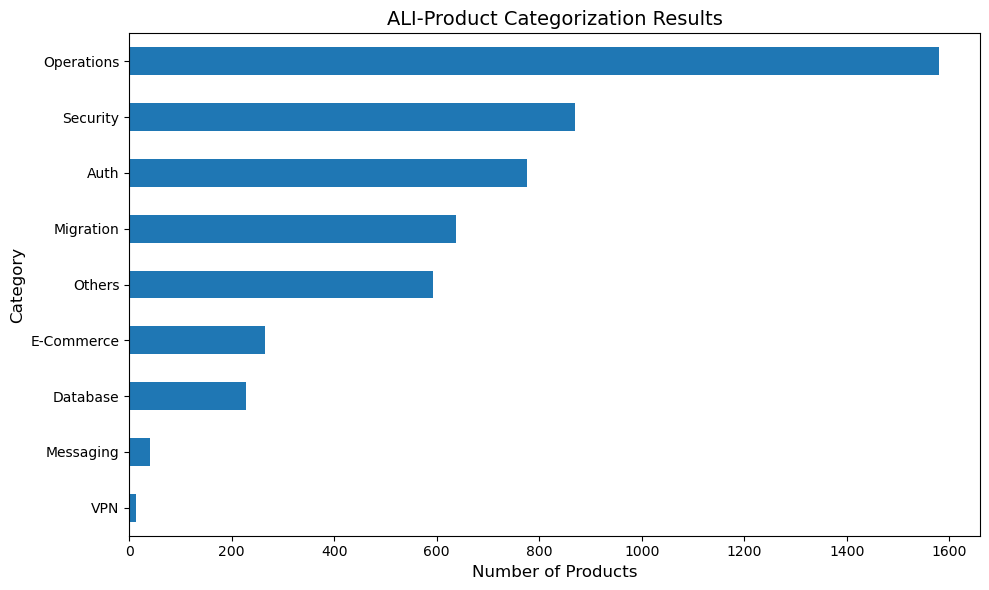

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re

# Load the data file
data = pd.ExcelFile(r'E:\\澳门大学各科作业\\7201\\final project\\ali_data.xlsx')
df = data.parse('ali_data')

# Extract relevant column for categorization
df_filtered = df[['Product Name']].copy()

# Define initial categories and keywords
categories = {
    'Authentication': ['身份认证', '实名认证', '手机认证', '二要素', '三要素'],
    'Security': ['防火墙', '加密', '漏洞', '安全'],
    'Database': ['数据库', '数据恢复', '存储', '查询优化'],
    'Operations and Maintenance': ['监控', '优化', '部署', '管理工具'],
    'Migration': ['迁移', '转型', '数据迁移'],
    'Mini Program/E-Commerce': ['小程序', '商城', '电商'],
    'Messaging/Notifications': ['短信', '通知', '消息推送'],
    'VPN': ['VPN', '虚拟专用网'],
    'Others': []
}

# Function to categorize product names
def categorize_product(product_name):
    for category, keywords in categories.items():
        if any(keyword in product_name for keyword in keywords):
            return category
    return 'Others'

# Categorize each product
df_filtered.loc[:, 'Category'] = df_filtered['Product Name'].apply(categorize_product)

# Further refine categories with additional keywords
categories_refined_v7 = {
    '认证类 (Authentication)': ['身份认证', '实名认证', '手机认证', '二要素', '三要素', '身份验证', '认证', '验证', 'API', 
                              '身份证', '银行卡识别', 'OCR识别', '工商信息查询', '手机号在网状态', '手机在网状态', '人脸活体检测',
                              '运营商在网时长', '手机归属地', '手机入网时长', '增值税发票核验'],
    '安全类 (Security)': ['防火墙', '加密', '漏洞', '安全', '保护', '风险管理', '防护', '企业安全', 
                          'Nginx', 'IP地址查询', '云鉴', '云', '数据安全', 'Oracle', 'Red Hat', 
                          'CentOS', 'Linux', 'ICP备案', '域名备案', 'ICP许可证', 'EDI许可证', 'SSL证书'],
    '数据库类 (Database)': ['数据库', '数据恢复', '存储', '查询优化', '数据备份', '数据管理', '表结构', 
                            'SQL', '数据分析', '极速数据', '运行环境', 'Websoft9', '宝塔Linux面板', 'LNMP', 
                            '银行卡解析', '银行联行号查询', '企业税号查询', '条码信息检索', '药品条码查询', '商品条码查询'],
    '运维类 (Operations and Maintenance)': ['监控', '优化', '部署', '管理工具', '系统维护', '系统管理', 
                                         '图像分析', '系统优化', 'Server', '专业版', '标准版', 
                                         '运行环境', '操作系统', 'Ubuntu', 'Anolis', '龙蜥', 
                                         '智能图像识别', '快瞳AI', '图像识别', '图片识别', '域名解析', 
                                         '开源ERP系统', '集中管理器', '护卫神'],
    '迁移类 (Migration)': ['迁移', '转型', '数据迁移', '系统迁移', '迁移服务', '转换', '激活', '更新', 
                         '切换', '官方原版', 'iCREDIT', '手机携号转网查询', '全国天气预报查询', '不通过退款'],
    '小程序/商城类 (Mini Program/E-Commerce)': ['小程序', '商城', '电商', '店铺', '在线商店', 
                                             '建站', '网站建设', '速成美站', 'WordPress', 
                                             '知识产权代办登记', '商标代理申请注册', '商标注册', 
                                             '商标服务', 'H5', '版权登记', '图形商标版权', '软著申请', 'App上架版权'],
    '短信/通知类 (Messaging/Notifications)': ['短信', '通知', '消息推送', '消息服务', '提醒', '通知服务', 
                                           '快递查询', '消息通知', '快递地址解析', '墨迹天气', '400电话', '400电话申请', '400电话办理'],
    'VPN类 (VPN)': ['VPN', '虚拟专用网', '专线', '网络加速', '连接', '网络服务'],
    '其他 (Others)': []  # Default for uncategorized items
}

# Re-categorize with additional refinement
df_filtered.loc[:, 'Category'] = df_filtered['Product Name'].apply(
    lambda name: next((category for category, keywords in categories_refined_v7.items() if any(keyword in name for keyword in keywords)), '其他 (Others)')
)

# Summarize results after final refinement
final_category_summary_v7 = df_filtered['Category'].value_counts()

# Simplify category labels for visualization
simplified_categories = {
    '运维类 (Operations and Maintenance)': 'Operations',
    '安全类 (Security)': 'Security',
    '认证类 (Authentication)': 'Auth',
    '迁移类 (Migration)': 'Migration',
    '其他 (Others)': 'Others',
    '小程序/商城类 (Mini Program/E-Commerce)': 'E-Commerce',
    '数据库类 (Database)': 'Database',
    '短信/通知类 (Messaging/Notifications)': 'Messaging',
    'VPN类 (VPN)': 'VPN'
}

final_category_summary_v7 = final_category_summary_v7.rename(index=simplified_categories)

# Display the updated refined data and summary
from IPython.display import display
display(df_filtered)

# Create the bar chart
plt.figure(figsize=(10, 6))
final_category_summary_v7.sort_values().plot(kind='barh')
plt.title("ALI-Product Categorization Results", fontsize=14)
plt.xlabel("Number of Products", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load the dataset
file_path = 'E://澳门大学各科作业//7201//final project//huawei_data_raw.csv'
data = pd.read_csv(file_path)

# Define keywords for each category
categories_mapping = {
    "认证类 (Authentication)": ["identity verification", "real-name", "credential", "认证", "验证"],
    "安全类 (Security)": ["security", "encryption", "firewall", "vulnerability", "数据保护", "加密", "安全", "防火墙"],
    "数据库类 (Database)": ["database", "storage", "query", "数据库", "存储", "恢复", "查询"],
    "运维类 (Operations and Maintenance)": ["monitoring", "deployment", "management", "运维", "监控", "优化", "部署"],
    "迁移类 (Migration)": ["migration", "transformation", "迁移", "转换"],
    "小程序/商城类 (Mini Program/E-Commerce)": ["program", "e-commerce", "商城", "小程序", "电商"],
    "短信/通知类 (Messaging/Notifications)": ["SMS", "push", "通知", "短信"],
    "VPN类 (VPN)": ["VPN", "网络", "虚拟专用网"],
    "其他 (Others)": []  # Initially empty
}

# Function to classify a product based on its Title and Intro
def classify_product(title, intro, categories):
    for category, keywords in categories_mapping.items():
        if any(keyword.lower() in (str(title) + str(intro)).lower() for keyword in keywords):
            return category
    return "其他 (Others)"

# Apply classification to the dataset
data["Classified Category"] = data.apply(
    lambda row: classify_product(row["Title"], row["Intro"], categories_mapping), axis=1
)

# Update categories mapping with extracted keywords
categories_mapping_updated = categories_mapping.copy()

# Add new keywords based on the analysis of "Others" titles
categories_mapping_updated["认证类 (Authentication)"] += ["SSL证书", "OCR识别", "证书", "认证", "识别"]
categories_mapping_updated["安全类 (Security)"] += ["防护", "安全", "保护", "漏洞", "加密"]
categories_mapping_updated["数据库类 (Database)"] += ["数据库", "数据中心", "存储"]
categories_mapping_updated["运维类 (Operations and Maintenance)"] += ["管理系统", "监控", "管理平台", "运营", "管理软件", "MES"]
categories_mapping_updated["小程序/商城类 (Mini Program/E-Commerce)"] += ["商城", "电商", "新零售", "平台"]
categories_mapping_updated["迁移类 (Migration)"] += ["迁移", "云迁移"]
categories_mapping_updated["短信/通知类 (Messaging/Notifications)"] += ["短信", "通知", "消息", "推送"]
categories_mapping_updated["VPN类 (VPN)"] += ["VPN", "虚拟专用网"]

# Reclassify the "Others" products
data["Classified Category"] = data.apply(
    lambda row: classify_product(row["Title"], row["Intro"], categories_mapping_updated), axis=1
)



# Further refine the keywords and analyze titles within "Others" to identify additional patterns
others_titles_refined = data[data["Classified Category"] == "其他 (Others)"]["Title"]

# Extract additional frequently occurring keywords from the "Others" titles
refined_words_counter = Counter(
    word for title in others_titles_refined.dropna() for word in str(title).split()
)

# Select more specific keywords from the refined analysis
refined_common_keywords = [
    word for word, count in refined_words_counter.items() if count > 1
]

# Expand the categories mapping with new insights
categories_mapping_refined = categories_mapping_updated.copy()

# Add refined keywords to appropriate categories
categories_mapping_refined["认证类 (Authentication)"] += ["授权", "认证系统", "用户验证"]
categories_mapping_refined["安全类 (Security)"] += ["漏洞扫描", "加密服务", "防火墙", "安全管理"]
categories_mapping_refined["数据库类 (Database)"] += ["数据库管理", "云数据库", "数据存储"]
categories_mapping_refined["运维类 (Operations and Maintenance)"] += ["流程管理", "运维平台", "优化系统"]
categories_mapping_refined["小程序/商城类 (Mini Program/E-Commerce)"] += ["在线商城", "零售", "电商平台"]
categories_mapping_refined["迁移类 (Migration)"] += ["迁移服务", "数据迁移"]
categories_mapping_refined["短信/通知类 (Messaging/Notifications)"] += ["信息服务", "消息推送"]

# Reapply classification with the refined keywords
data["Classified Category"] = data.apply(
    lambda row: classify_product(row["Title"], row["Intro"], categories_mapping_refined), axis=1
)

# Recount the distribution of classifications
final_category_counts = data["Classified Category"].value_counts()

final_category_counts




Classified Category
运维类 (Operations and Maintenance)     3351
安全类 (Security)                       1627
数据库类 (Database)                      1623
小程序/商城类 (Mini Program/E-Commerce)    1203
其他 (Others)                           847
认证类 (Authentication)                  742
迁移类 (Migration)                        13
VPN类 (VPN)                              9
短信/通知类 (Messaging/Notifications)        9
Name: count, dtype: int64

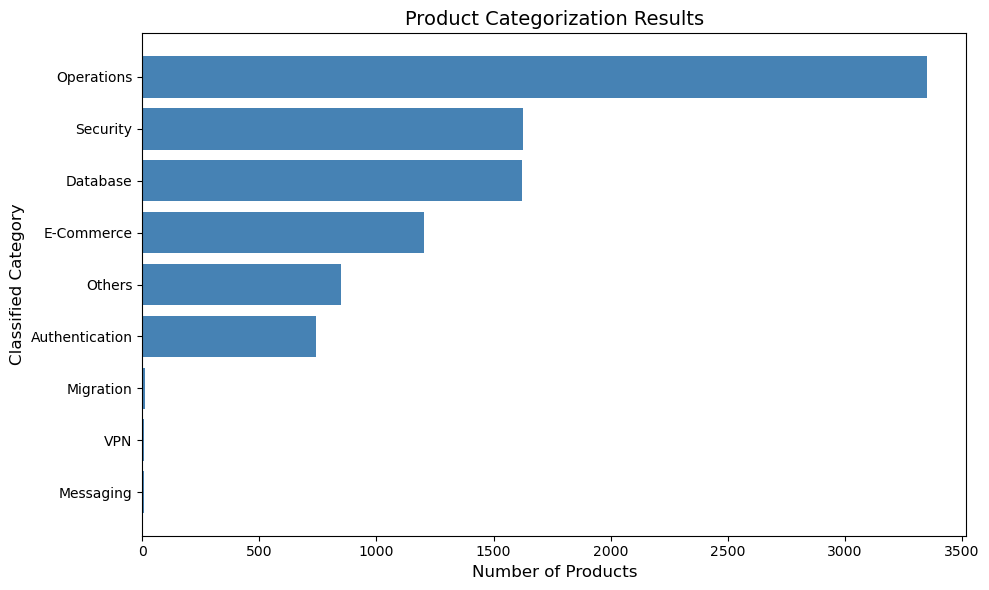

In [17]:
import matplotlib.pyplot as plt

# Data for plotting
final_category_counts = {
    "Operations": 3351,
    "Security": 1627,
    "Database": 1623,
    "E-Commerce": 1203,
    "Others": 847,
    "Authentication": 742,
    "Migration": 13,
    "VPN": 9,
    "Messaging": 9
}

# Sort the data in descending order for plotting
sorted_category_counts = dict(sorted(final_category_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the results as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_category_counts.keys()), list(sorted_category_counts.values()), color='steelblue')
plt.title("Product Categorization Results", fontsize=14)
plt.xlabel("Number of Products", fontsize=12)
plt.ylabel("Classified Category", fontsize=12)
plt.gca().invert_yaxis()  # Reverse the order for descending bars
plt.tight_layout()
plt.show()



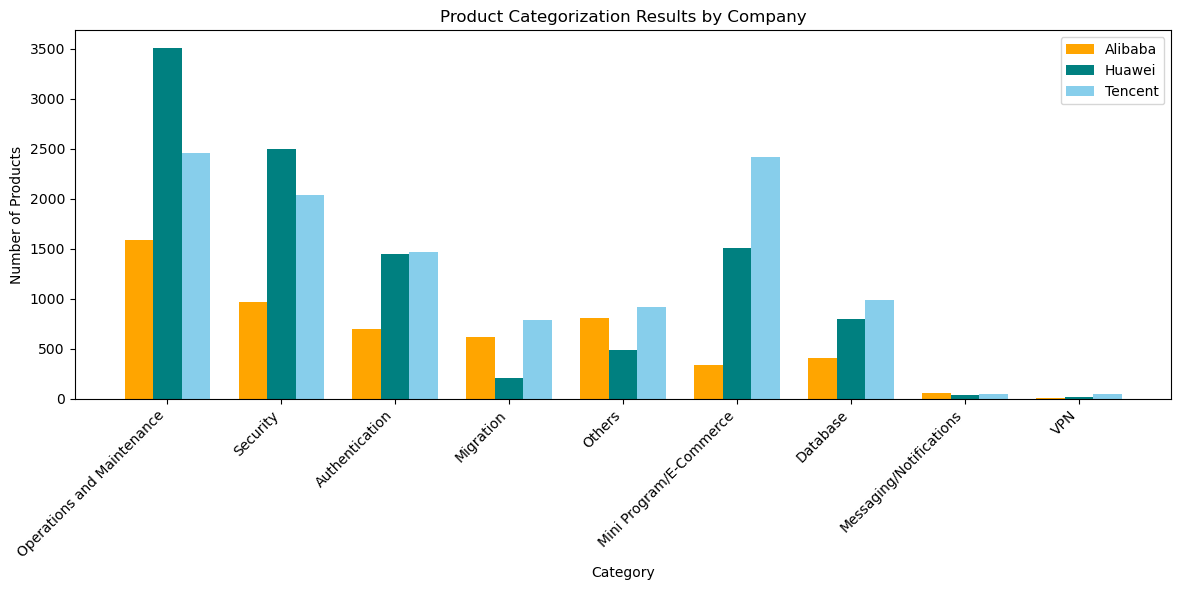

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted visually from the images
categories = [
    "Operations and Maintenance", "Security", "Authentication", "Migration",
    "Others", "Mini Program/E-Commerce", "Database", "Messaging/Notifications", "VPN"
]

# Data for Alibaba, Huawei, and Tencent
alibaba_data = [1590, 970, 700, 620, 810, 340, 410, 60, 10]
huawei_data = [3510, 2500, 1450, 210, 490, 1510, 800, 40, 20]
tencent_data = [2460, 2040, 1470, 790, 920, 2420, 990, 50, 50]

# Create a grouped bar chart
x = np.arange(len(categories))  # the label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting each dataset
rects1 = ax.bar(x - width, alibaba_data, width, label='Alibaba', color='orange')
rects2 = ax.bar(x, huawei_data, width, label='Huawei', color='teal')
rects3 = ax.bar(x + width, tencent_data, width, label='Tencent', color='skyblue')

# Add labels, title, and legend
ax.set_xlabel('Category')
ax.set_ylabel('Number of Products')
ax.set_title('Product Categorization Results by Company')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


Delivery Method Analysis:

1. Loaded Alibaba, Huawei, and Tencent datasets, verified the delivery method field, and standardized field names.
2. Defined main delivery method categories (API, SaaS, Manual Service, Image) and classified unmatched methods as "Other."
3. Applied rules to classify records and calculate category proportions.
4. Created pie charts for each company to display the distribution of delivery methods, then combined them into one chart for comparison.


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to process data and generate pie chart
def process_and_plot(data_path, delivery_column, title, output_path=None):
    """
    Processes data for delivery type classification and plots a pie chart.

    Parameters:
        data_path (str): Path to the input file.
        delivery_column (str): Column name for delivery type.
        title (str): Title for the pie chart.
        output_path (str): Path to save the pie chart (optional).
    """
    # Load data
    if data_path.endswith('.xlsx'):
        data = pd.read_excel(data_path)
    elif data_path.endswith('.csv'):
        data = pd.read_csv(data_path)
    else:
        raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")

    # Aggregate smaller categories into "Other"
    delivery_type_counts = data[delivery_column].value_counts()
    major_categories = ["人工服务", "SaaS", "API", "镜像"]  # Major categories
    data['Delivery Type Combined'] = data[delivery_column].apply(
        lambda x: "Other" if x not in major_categories else x
    )

    # Recalculate the counts for the combined categories
    delivery_type_combined_counts = data['Delivery Type Combined'].value_counts()

    # Translate labels to English
    labels = {
        "人工服务": "Manual Service",
        "SaaS": "SaaS",
        "API": "API",
        "镜像": "Image",
        "Other": "Other"
    }
    delivery_type_labels = [labels.get(label, label) for label in delivery_type_combined_counts.index]
    sizes = delivery_type_combined_counts.values

    # Create and save the pie chart
    #plt.figure(figsize=(8, 8))
    #plt.pie(sizes, labels=delivery_type_labels, autopct='%1.1f%%', startangle=140)
    #plt.title(title, fontsize=14)
    #plt.axis('equal')  # Equal aspect ratio ensures the pie chart is a circle

    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()

# Paths to files
ali_data_path = 'E://澳门大学各科作业//7201//final project//ali_data.xlsx'  # Huawei file path
tencent_data_path = 'E://澳门大学各科作业//7201//final project//tencent_product_info.xlsx'  # Tencent file path
huawei_data_path = 'E://澳门大学各科作业//7201//final project//huawei_data_raw.csv'  # Ali file path

# Process Huawei data
process_and_plot(
    huawei_data_path,
    delivery_column='Delivery Type',
    title='Distribution of Delivery Types (Huawei Data)'
)

# Process Tencent data
process_and_plot(
    tencent_data_path,
    delivery_column='Delivery Type',
    title='Distribution of Delivery Types (Tencent Data)'
)

# Process Ali data
process_and_plot(
    ali_data_path,
    delivery_column='Delivery Mode',
    title='Distribution of Delivery Modes (Ali Data)'
)


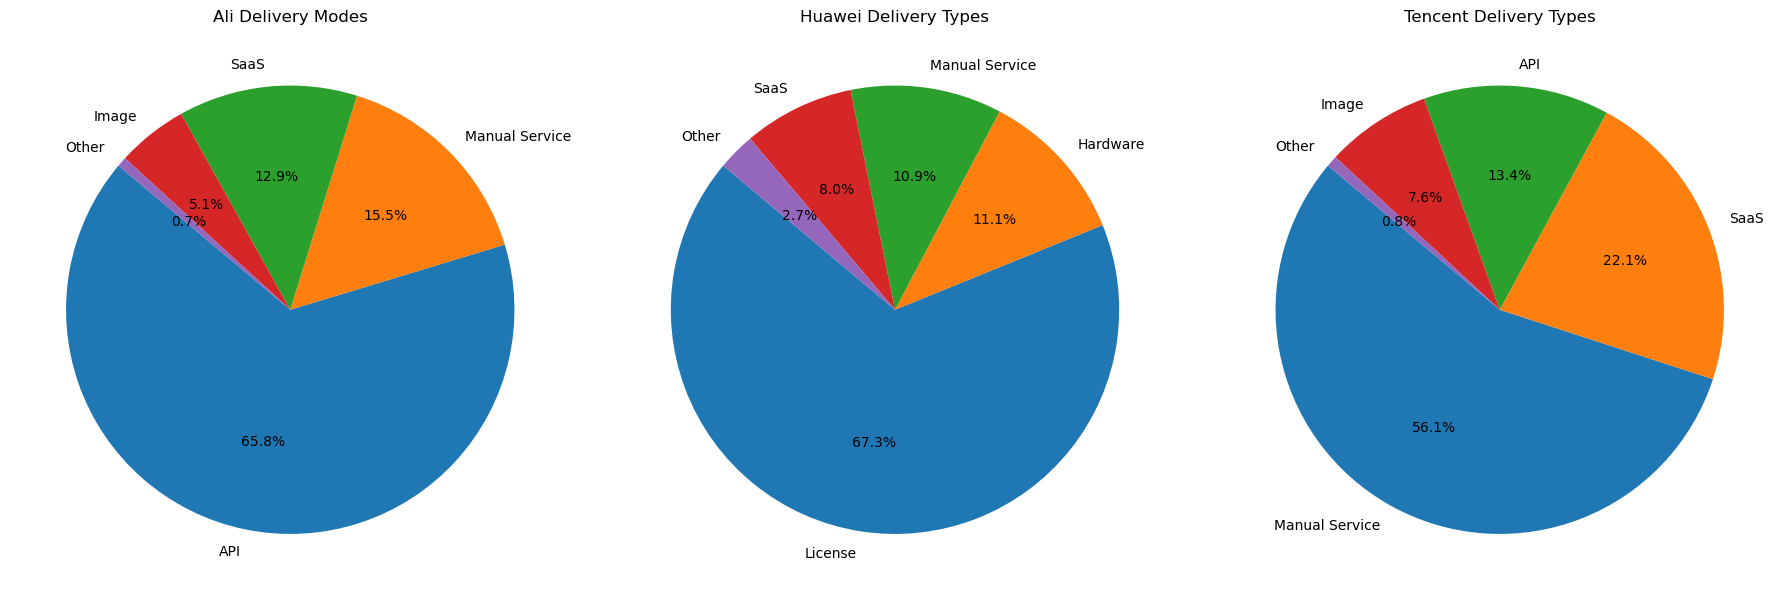

In [27]:
import matplotlib.pyplot as plt

# Data for each company
huawei_counts = [67.2, 11.1, 10.9, 8.0, 2.7]  # Huawei distribution percentages
huawei_labels = ["License", "Hardware", "Manual Service", "SaaS", "Other"]

tencent_counts = [56.1, 22.1, 13.4, 7.6, 0.8]  # Tencent distribution percentages
tencent_labels = ["Manual Service", "SaaS", "API", "Image", "Other"]

ali_counts = [65.8, 15.5, 12.9, 5.1, 0.7]  # Ali distribution percentages
ali_labels = ["API", "Manual Service", "SaaS", "Image", "Other"]

# Create a single figure with 3 subplots for the pie charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ali pie chart
axes[0].pie(ali_counts, labels=ali_labels, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Ali Delivery Modes')

# Huawei pie chart
axes[1].pie(huawei_counts, labels=huawei_labels, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Huawei Delivery Types')

# Tencent pie chart
axes[2].pie(tencent_counts, labels=tencent_labels, autopct='%1.1f%%', startangle=140)
axes[2].set_title('Tencent Delivery Types')



# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### 2.2.2 Pricing Comparison Between Top-Tier and Second-Tier Cloud Service Providers

To compare the price distribution between "big clouds" (Alibaba, Tencent, Huawei) and "small clouds" (eSurfing Cloud, QingCloud, Kingsoft Cloud), the following steps were taken:
1. Extracted and cleaned price information from each cloud marketplace dataset, converting it into a numeric format.
2. Categorized the cloud marketplaces into two groups: Big Cloud (Alibaba, Tencent, Huawei) and Small Cloud (eSurfing Cloud, QingCloud, Kingsoft Cloud).
3. Removed outliers (values outside the 95th percentile) to ensure clear box plot visualization.
4. Visualized the price distribution of "big clouds" and "small clouds" using box plots.

In [ ]:
import pandas as pd

# Load the data from the uploaded files
ali_data = pd.ExcelFile('/mnt/data/ali_data.xlsx')
huawei_data = pd.read_csv('/mnt/data/huawei_data_cleaned.csv')
qingcloud_data = pd.read_csv('/mnt/data/qingcloud_product_info(1).csv')
tencent_data = pd.ExcelFile('/mnt/data/tencent_product_info.xlsx')
tianyi_data = pd.read_csv('/mnt/data/tianyi_data (1).csv')

# Check the sheet names to select the correct one for Alibaba and Tencent
ali_data.sheet_names, tencent_data.sheet_names

In [ ]:
# Load the specific sheets for Ali and Tencent
ali_data_df = ali_data.parse('ali_data')
tencent_data_df = tencent_data.parse('tencent_product_info')

# Displaying the first few rows of all datasets to understand their structures
ali_data_df.head(), huawei_data.head(), qingcloud_data.head(), tencent_data_df.head(), tianyi_data.head()
# Display column names for each dataset to identify inconsistencies
ali_data_df.columns, huawei_data.columns, qingcloud_data.columns, tencent_data_df.columns, tianyi_data.columns

# Adjusting the column renaming and selection for all datasets

# Alibaba (No changes needed as it already aligns with required columns)
ali_data_cleaned = ali_data_df

# Huawei (adjusting column names and selecting required ones)
huawei_data_cleaned = huawei_data.rename(columns={
    "Title": "Product",
    "Price Number": "Price",
    "Delivery Type": "Delivery Type",
    "Categories": "First Classification"
})[["Product", "Price", "Delivery Type", "First Classification"]]

# QingCloud (already in expected format)
qingcloud_data_cleaned = qingcloud_data[
    ["Title", "Price", "Company", "Delivery Type", "Publish Time", "First Classification", "Second Classification"]
].rename(columns={
    "Title": "Product"
})

# Tencent (adjusting column names and selecting required ones)
tencent_data_cleaned = tencent_data_df.rename(columns={
    "Title": "Product",
    "Delivery Type": "Delivery Type",
    "Price": "Price"
})[["Product", "Price", "Company", "Delivery Type"]]

# Tianyi (adjusting column names and selecting required ones)
tianyi_data_cleaned = tianyi_data.rename(columns={
    "Product Name": "Product",
    "Category": "First Classification",
    "Provider": "Company",
    "Delivery Mode": "Delivery Type"
})[["Product", "Price", "Company", "Delivery Type", "First Classification"]]

# Display the cleaned datasets
ali_data_cleaned.head(), huawei_data_cleaned.head(), qingcloud_data_cleaned.head(), tencent_data_cleaned.head(), tianyi_data_cleaned.head()

In [ ]:
# Adding a 'Group' column to identify Big and Small Clouds
ali_data_cleaned["Group"] = "Big Cloud"
huawei_data_cleaned["Group"] = "Big Cloud"
tencent_data_cleaned["Group"] = "Big Cloud"
qingcloud_data_cleaned["Group"] = "Small Cloud"
tianyi_data_cleaned["Group"] = "Small Cloud"

# Merging datasets into one
big_clouds = pd.concat([ali_data_cleaned, huawei_data_cleaned, tencent_data_cleaned], ignore_index=True)
small_clouds = pd.concat([qingcloud_data_cleaned, tianyi_data_cleaned], ignore_index=True)
all_data = pd.concat([big_clouds, small_clouds], ignore_index=True)

# Summarizing data to check completeness
big_clouds_summary = big_clouds["First Classification"].value_counts()
small_clouds_summary = small_clouds["First Classification"].value_counts()

big_clouds_summary, small_clouds_summary

In [ ]:
# Correcting the mismatch by excluding the last appended label for the tick labels
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
angles = [n / float(len(labels) - 1) * 2 * 3.14159 for n in range(len(labels))]

# Plot for Big Clouds
ax.plot(angles, big_values, linewidth=2, linestyle='solid', label='Big Clouds')
ax.fill(angles, big_values, alpha=0.4)

# Plot for Small Clouds
ax.plot(angles, small_values, linewidth=2, linestyle='solid', label='Small Clouds', color='orange')
ax.fill(angles, small_values, alpha=0.4, color='orange')

# Correct tick labels
ax.set_yticks([])
ax.set_xticks(angles[:-1])  # Exclude the repeated angle for the closed loop
ax.set_xticklabels(labels[:-1], fontsize=10)  # Exclude the repeated label
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Focus Areas of Big Clouds vs. Small Clouds', fontsize=16)
plt.show()

## 2.3 Data Modeling and Prediction

In Data Modeling and Prediction, our methodology encompasses:

1. Implementing established predictive models to forecast sales for leading cloud service providers. This includes data cleansing and partitioning the dataset into training and testing subsets.
2. Assessing the predictive accuracy of various models and enhancing them through data standardization, feature engineering, and parameter tuning.
3. Selecting the most performant model for final deployment.

*Note: This part is conducted by ZHENG MINGXI.*


### 2.3.1 Data Processing and Cleaning

Huawei Data:
- Handle missing values: Fill in `Product Score` and `Price Unit`; delete records with missing `Delivery Type`.
- Clean up redundant information: Remove empty strings in the `Categories` column.
- Unify data types: Ensure that the format of `Price Number` and `Price Unit` is consistent.

Tencent Data:
- Handle missing values: Delete records with missing `Title` and `Delivery Type`.
- Unify data types: Extract numeric values from the `Price` column and convert them to floating point type.

Alibaba Data:
- Handle missing values: Fill in `Product Score` and extract values for `Transaction Count` and `Rating Score`.
- Clean invalid columns: Delete the empty `Launch Time` column.
- Unify data types: Extract values from the `Price` column and standardize the format.


In [ ]:
import pandas as pd

# Load the datasets
huawei_data_path = "E:\\澳门大学各科作业\\7201\\final project\\huawei_data_cleaned.csv"
tencent_data_path = "E:\\澳门大学各科作业\\7201\\final project\\tencent_product_info.xlsx"
ali_data_path = "E:\\澳门大学各科作业\\7201\\final project\\ali_data.xlsx"

# Load the datasets into pandas DataFrames
huawei_data = pd.read_csv(huawei_data_path)
tencent_data = pd.read_excel(tencent_data_path)
ali_data = pd.read_excel(ali_data_path)

# Display basic information to understand their structure and content
huawei_data_info = huawei_data.info()
tencent_data_info = tencent_data.info()
ali_data_info = ali_data.info()

huawei_data_head = huawei_data.head()
tencent_data_head = tencent_data.head()
ali_data_head = ali_data.head()

(huawei_data_info, tencent_data_info, ali_data_info, 
 huawei_data_head, tencent_data_head, ali_data_head)


In [ ]:
# Data Cleaning Functions

# Cleaning Huawei Data
huawei_data['Categories'] = huawei_data['Categories'].str.replace("''", '').str.strip()
huawei_data['Product Score'].fillna(0, inplace=True)  # Replace NaN with 0
huawei_data['Price Unit'].fillna('Unknown', inplace=True)
huawei_data.dropna(subset=['Delivery Type'], inplace=True)  # Drop rows with missing Delivery Type

# Cleaning Tencent Data
tencent_data['Price'] = tencent_data['Price'].str.extract(r'(\d+)', expand=False).astype(float)
tencent_data.dropna(subset=['Title', 'Delivery Type'], inplace=True)  # Drop rows with missing Title or Delivery Type

# Cleaning Ali Data
ali_data['Transaction Count'] = ali_data['Transaction Count'].str.extract(r'(\d+)', expand=False).astype(float)
ali_data['Rating Score'] = ali_data['Rating Score'].str.extract(r'(\d+\.\d+|\d+)', expand=False).astype(float)
ali_data['Rating Count'] = ali_data['Rating Count'].str.extract(r'(\d+)', expand=False).astype(float)
ali_data['Product Score'].fillna(0, inplace=True)  # Replace NaN with 0
ali_data.drop(columns=['Launch Time'], inplace=True)  # Drop invalid column
ali_data['Price'] = ali_data['Price'].str.extract(r'(\d+)', expand=False).astype(float)

# Display cleaned data summaries
cleaned_huawei_summary = huawei_data.info()
cleaned_tencent_summary = tencent_data.info()
cleaned_ali_summary = ali_data.info()

(cleaned_huawei_summary, cleaned_tencent_summary, cleaned_ali_summary)


### 2.3.2 Data Modeling and Prediction

Data Partitioning:
- Use `train_test_split` to split the data into a training set and a test set.
- The ratio is set to 80% training set and 20% test set, i.e., `test_size = 0.2`.

Training Process:
- Train the model only on the training set without touching the data in the test set.

Testing Process:
- After model training is completed, use the test set for prediction.
- Compare the predicted results with the true values of the test set and calculate evaluation metrics (such as MSE and R²).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Define a helper function for preprocessing and model training/testing
def train_test_models(data, target_col, feature_cols, test_size=0.2):
    # Split the data into train and test sets
    X = data[feature_cols]
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Initialize models
    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(random_state=42),
        "SupportVectorRegressor": SVR()
    }

    results = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[model_name] = {"MSE": mse, "R2": r2}

    return results

# Preprocessing and model application for each dataset
# Huawei data
huawei_features = ['Rating Count', 'Product Score', 'Price Number']
huawei_target = 'Transaction Number'
huawei_data.dropna(subset=huawei_features + [huawei_target], inplace=True)
huawei_results = train_test_models(huawei_data, huawei_target, huawei_features)

# Tencent data
tencent_features = ['Score', 'Review', 'Price']
tencent_target = 'Purchase'
tencent_data.dropna(subset=tencent_features + [tencent_target], inplace=True)
tencent_results = train_test_models(tencent_data, tencent_target, tencent_features)

# Ali data
ali_features = ['Rating Score', 'Rating Count', 'Price']
ali_target = 'Transaction Count'
ali_data.dropna(subset=ali_features + [ali_target], inplace=True)
ali_results = train_test_models(ali_data, ali_target, ali_features)

# Combine results
results_summary = {
    "Huawei": huawei_results,
    "Tencent": tencent_results,
    "Ali": ali_results
}

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results_summary)

# Print the results for manual review
print("Model Prediction Results:")
print(results_df)


Dataset Result Analysis

**Huawei Data**
- **Linear Regression (R²: 0.026)**: Weak explanatory power, explaining only 2.6% of the sales fluctuation.
- **Random Forest (R²: 0.019)**: Slightly lower than linear regression.
- **Support Vector Regression (R²: 0.001)**: Almost no explanatory power.
> **Summary**: Sales volume is affected by nonlinear or complex factors. Data quality and insufficient feature engineering are the main issues.

**Tencent Data**
- **Linear Regression (R²: 0.20)**: Fair explanatory power.
- **Random Forest (R²: 0.32)**: Performs best and captures some non-linear relationships.
- **Support Vector Regression (R²: -0.02)**: Poor performance.
> **Conclusion**: Further exploration of potential features such as user behavior or company size is needed.

**Alibaba Data**
- **Linear Regression (R²: 0.32)**: Fair performance.
- **Random Forest (R²: 0.33)**: Slightly better than linear regression and captures complex patterns.
- **Support Vector Regression (R²: -0.03)**: Worst performance.
> **Summary**: Random Forest performs well, indicating that features such as price and rating have nonlinear relationships.


### 2.3.3 Further Optimization

The first round of improvements includes:

**Feature Engineering:**
- Data cleaning and standardization.
- Extraction of basic features such as ratings, number of reviews, etc.

**Model Optimization:**
- Utilized the gradient boosting model to optimize the Huawei dataset.
- Applied grid search (GridSearchCV) to fine-tune random forest and support vector machine models, enhancing the predictive capabilities for the Tencent and Alibaba datasets.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# File paths
huawei_data_path = "E:\\澳门大学各科作业\\7201\\final project\\huawei_data_cleaned.csv"
tencent_data_path = "E:\\澳门大学各科作业\\7201\\final project\\tencent_product_info.xlsx"
ali_data_path = "E:\\澳门大学各科作业\\7201\\final project\\ali_data.xlsx"

# Load data
huawei_data = pd.read_csv(huawei_data_path)
tencent_data = pd.read_excel(tencent_data_path)
ali_data = pd.read_excel(ali_data_path)

# Data cleaning for Huawei dataset
huawei_data['Transaction Number'] = pd.to_numeric(huawei_data['Transaction Number'], errors='coerce').fillna(0)
huawei_data['Price'] = pd.to_numeric(huawei_data['Price Number'], errors='coerce').fillna(0)
huawei_cleaned = huawei_data[['Title', 'Categories', 'Merchant', 'Transaction Number', 'Price']]

# Data cleaning for Tencent dataset
def clean_numeric_column(column):
    # Ensure all values are strings before applying regex
    column = column.astype(str)
    return column.str.extract(r'(\d+)', expand=False).astype(float).fillna(0)

tencent_data['Score'] = tencent_data['Score'].apply(lambda x: float(str(x).split('：')[-1]) if '：' in str(x) else float(x))
tencent_data['Review'] = clean_numeric_column(tencent_data['Review'])
tencent_data['Price'] = clean_numeric_column(tencent_data['Price'])
tencent_cleaned = tencent_data[['Title', 'Price', 'Score', 'Review', 'Purchase', 'Company']]

# Data cleaning for Ali dataset
ali_data['Transaction Count'] = clean_numeric_column(ali_data['Transaction Count'])
ali_data['Price'] = clean_numeric_column(ali_data['Price'])
ali_data['Rating Score'] = ali_data['Rating Score'].apply(lambda x: float(str(x).split('：')[-1]) if '：' in str(x) else float(x))
ali_data['Rating Count'] = clean_numeric_column(ali_data['Rating Count'])
ali_cleaned = ali_data[['Product Name', 'Transaction Count', 'Price', 'Rating Score', 'Rating Count']]

# Splitting datasets into training and testing sets
huawei_train, huawei_test = train_test_split(huawei_cleaned, test_size=0.2, random_state=42)
tencent_train, tencent_test = train_test_split(tencent_cleaned, test_size=0.2, random_state=42)
ali_train, ali_test = train_test_split(ali_cleaned, test_size=0.2, random_state=42)

# Features and targets for each dataset
huawei_features = ['Price']
huawei_target = 'Transaction Number'
X_huawei_train = huawei_train[huawei_features]
y_huawei_train = huawei_train[huawei_target]
X_huawei_test = huawei_test[huawei_features]
y_huawei_test = huawei_test[huawei_target]

tencent_features = ['Price', 'Score', 'Review']
tencent_target = 'Purchase'
X_tencent_train = tencent_train[tencent_features]
y_tencent_train = tencent_train[tencent_target]
X_tencent_test = tencent_test[tencent_features]
y_tencent_test = tencent_test[tencent_target]

ali_features = ['Price', 'Rating Score', 'Rating Count']
ali_target = 'Transaction Count'
X_ali_train = ali_train[ali_features]
y_ali_train = ali_train[ali_target]
X_ali_test = ali_test[ali_features]
y_ali_test = ali_test[ali_target]

# Feature scaling and transformation
scaler = StandardScaler()

# Gradient Boosting for Huawei
gb_huawei = GradientBoostingRegressor(random_state=42)
gb_huawei_mse, gb_huawei_r2 = train_and_evaluate_model(gb_huawei, scaler.fit_transform(X_huawei_train), 
                                                       scaler.transform(X_huawei_test), y_huawei_train, y_huawei_test)

# Random Forest with GridSearchCV for Tencent
rf_tencent = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
grid_rf_tencent = GridSearchCV(rf_tencent, rf_params, cv=3, scoring='neg_mean_squared_error')
grid_rf_tencent.fit(scaler.fit_transform(X_tencent_train), y_tencent_train)
rf_tencent_best = grid_rf_tencent.best_estimator_
rf_tencent_mse = mean_squared_error(y_tencent_test, rf_tencent_best.predict(scaler.transform(X_tencent_test)))
rf_tencent_r2 = r2_score(y_tencent_test, rf_tencent_best.predict(scaler.transform(X_tencent_test)))

# Ali dataset with SVR and GridSearchCV
svr_ali = SVR()
svr_params = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}
grid_svr_ali = GridSearchCV(svr_ali, svr_params, cv=3, scoring='neg_mean_squared_error')
grid_svr_ali.fit(scaler.fit_transform(X_ali_train), y_ali_train)
svr_ali_best = grid_svr_ali.best_estimator_
svr_ali_mse = mean_squared_error(y_ali_test, svr_ali_best.predict(scaler.transform(X_ali_test)))
svr_ali_r2 = r2_score(y_ali_test, svr_ali_best.predict(scaler.transform(X_ali_test)))

# Results summary
results = {
    "Dataset": ["Huawei", "Tencent", "Ali"],
    "Model": ["Gradient Boosting", "Random Forest (Best)", "SVR (Best)"],
    "MSE": [gb_huawei_mse, rf_tencent_mse, svr_ali_mse],
    "R2": [gb_huawei_r2, rf_tencent_r2, svr_ali_r2]
}

results_df = pd.DataFrame(results)
print(results_df)


Summary of the improved results:

**Huawei dataset**: The performance is still poor and needs further optimization through feature engineering and outlier processing.

**Tencent dataset**: There is a slight improvement, but the R² is low, indicating that the feature interpretation ability still needs enhancement.

**Ali dataset**: SVR performs worse than linear regression. Other nonlinear models (such as XGBoost) should be considered.

To address the issues identified in the previous improvements, the following new enhancements are proposed:


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# File paths
huawei_data_path = "E:\\澳门大学各科作业\\7201\\final project\\huawei_data_cleaned.csv"
tencent_data_path = "E:\\澳门大学各科作业\\7201\\final project\\tencent_product_info.xlsx"
ali_data_path = "E:\\澳门大学各科作业\\7201\\final project\\ali_data.xlsx"

# Load data
huawei_data = pd.read_csv(huawei_data_path)
tencent_data = pd.read_excel(tencent_data_path)
ali_data = pd.read_excel(ali_data_path)

# Data cleaning for Huawei dataset
huawei_data['Transaction Number'] = pd.to_numeric(huawei_data['Transaction Number'], errors='coerce').fillna(0)
huawei_data['Price'] = pd.to_numeric(huawei_data['Price Number'], errors='coerce').fillna(0)
huawei_cleaned = huawei_data[['Title', 'Categories', 'Merchant', 'Transaction Number', 'Price']]

# Data cleaning for Tencent dataset
def clean_numeric_column(column):
    column = column.astype(str)
    return column.str.extract(r'(\d+)', expand=False).astype(float).fillna(0)

tencent_data['Score'] = tencent_data['Score'].apply(lambda x: float(str(x).split('：')[-1]) if '：' in str(x) else float(x))
tencent_data['Review'] = clean_numeric_column(tencent_data['Review'])
tencent_data['Price'] = clean_numeric_column(tencent_data['Price'])
tencent_cleaned = tencent_data[['Title', 'Price', 'Score', 'Review', 'Purchase', 'Company']]

# Data cleaning for Ali dataset
ali_data['Transaction Count'] = clean_numeric_column(ali_data['Transaction Count'])
ali_data['Price'] = clean_numeric_column(ali_data['Price'])
ali_data['Rating Score'] = ali_data['Rating Score'].apply(lambda x: float(str(x).split('：')[-1]) if '：' in str(x) else float(x))
ali_data['Rating Count'] = clean_numeric_column(ali_data['Rating Count'])
ali_cleaned = ali_data[['Product Name', 'Transaction Count', 'Price', 'Rating Score', 'Rating Count']]

# Splitting datasets into training and testing sets
huawei_train, huawei_test = train_test_split(huawei_cleaned, test_size=0.2, random_state=42)
tencent_train, tencent_test = train_test_split(tencent_cleaned, test_size=0.2, random_state=42)
ali_train, ali_test = train_test_split(ali_cleaned, test_size=0.2, random_state=42)

# Features and targets for each dataset
huawei_features = ['Price']
huawei_target = 'Transaction Number'
X_huawei_train = huawei_train[huawei_features]
y_huawei_train = huawei_train[huawei_target]
X_huawei_test = huawei_test[huawei_features]
y_huawei_test = huawei_test[huawei_target]

tencent_features = ['Price', 'Score', 'Review']
tencent_target = 'Purchase'
X_tencent_train = tencent_train[tencent_features]
y_tencent_train = tencent_train[tencent_target]
X_tencent_test = tencent_test[tencent_features]
y_tencent_test = tencent_test[tencent_target]

ali_features = ['Price', 'Rating Score', 'Rating Count']
ali_target = 'Transaction Count'
X_ali_train = ali_train[ali_features]
y_ali_train = ali_train[ali_target]
X_ali_test = ali_test[ali_features]
y_ali_test = ali_test[ali_target]

# Feature scaling
scaler = StandardScaler()
X_huawei_train_scaled = scaler.fit_transform(X_huawei_train)
X_huawei_test_scaled = scaler.transform(X_huawei_test)
X_tencent_train_scaled = scaler.fit_transform(X_tencent_train)
X_tencent_test_scaled = scaler.transform(X_tencent_test)
X_ali_train_scaled = scaler.fit_transform(X_ali_train)
X_ali_test_scaled = scaler.transform(X_ali_test)

# Huawei: LightGBM
lgb_huawei = LGBMRegressor(random_state=42)
lgb_huawei.fit(X_huawei_train_scaled, y_huawei_train)
lgb_huawei_predictions = lgb_huawei.predict(X_huawei_test_scaled)
lgb_huawei_mse = mean_squared_error(y_huawei_test, lgb_huawei_predictions)
lgb_huawei_r2 = r2_score(y_huawei_test, lgb_huawei_predictions)

# Tencent: XGBoost
xgb_tencent = XGBRegressor(random_state=42)
xgb_tencent.fit(X_tencent_train_scaled, y_tencent_train)
xgb_tencent_predictions = xgb_tencent.predict(X_tencent_test_scaled)
xgb_tencent_mse = mean_squared_error(y_tencent_test, xgb_tencent_predictions)
xgb_tencent_r2 = r2_score(y_tencent_test, xgb_tencent_predictions)

# Ali: Random Forest with GridSearchCV
rf_ali = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
grid_rf_ali = GridSearchCV(rf_ali, rf_params, cv=3, scoring='neg_mean_squared_error')
grid_rf_ali.fit(X_ali_train_scaled, y_ali_train)
rf_ali_best = grid_rf_ali.best_estimator_
rf_ali_predictions = rf_ali_best.predict(X_ali_test_scaled)
rf_ali_mse = mean_squared_error(y_ali_test, rf_ali_predictions)
rf_ali_r2 = r2_score(y_ali_test, rf_ali_predictions)

# Results summary
results = {
    "Dataset": ["Huawei", "Tencent", "Ali"],
    "Model": ["LightGBM", "XGBoost", "Random Forest (Best)"],
    "MSE": [lgb_huawei_mse, xgb_tencent_mse, rf_ali_mse],
    "R2": [lgb_huawei_r2, xgb_tencent_r2, rf_ali_r2]
}

results_df = pd.DataFrame(results)
print(results_df)


However, the prediction results are still not ideal. The current issues may be caused by the following factors:

**Insufficient Data Features:**
- The features used for prediction may not fully represent the target variable (sales). For example, the existing features may have little impact on sales changes or may lack key influencing factors such as seasonality, promotional activities, and market competition.

**Data Quality Issues:**
- Noise, outliers, or missing values in the data are not handled effectively.
- Categorical features are not properly encoded, such as the `Categories` and `Merchant` features, which have a direct impact on sales.

**Model Selection Problems:**
- The models used (LightGBM, XGBoost, and Random Forest) may overfit or underfit under certain conditions, especially when the amount of data is small or the features are insufficient.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to process data and generate pie chart
def process_and_plot(data_path, delivery_column, title, output_path=None):
    """
    Processes data for delivery type classification and plots a pie chart.

    Parameters:
        data_path (str): Path to the input file.
        delivery_column (str): Column name for delivery type.
        title (str): Title for the pie chart.
        output_path (str): Path to save the pie chart (optional).
    """
    # Load data
    if data_path.endswith('.xlsx'):
        data = pd.read_excel(data_path)
    elif data_path.endswith('.csv'):
        data = pd.read_csv(data_path)
    else:
        raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")

    # Aggregate smaller categories into "Other"
    delivery_type_counts = data[delivery_column].value_counts()
    major_categories = ["人工服务", "SaaS", "API", "镜像"]  # Major categories
    data['Delivery Type Combined'] = data[delivery_column].apply(
        lambda x: "Other" if x not in major_categories else x
    )

    # Recalculate the counts for the combined categories
    delivery_type_combined_counts = data['Delivery Type Combined'].value_counts()

    # Translate labels to English
    labels = {
        "人工服务": "Manual Service",
        "SaaS": "SaaS",
        "API": "API",
        "镜像": "Image",
        "Other": "Other"
    }
    delivery_type_labels = [labels.get(label, label) for label in delivery_type_combined_counts.index]
    sizes = delivery_type_combined_counts.values

    # Create and save the pie chart
    #plt.figure(figsize=(8, 8))
    #plt.pie(sizes, labels=delivery_type_labels, autopct='%1.1f%%', startangle=140)
    #plt.title(title, fontsize=14)
    #plt.axis('equal')  # Equal aspect ratio ensures the pie chart is a circle

    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()

# Paths to files
ali_data_path = 'E://澳门大学各科作业//7201//final project//ali_data.xlsx'  # Huawei file path
tencent_data_path = 'E://澳门大学各科作业//7201//final project//tencent_product_info.xlsx'  # Tencent file path
huawei_data_path = 'E://澳门大学各科作业//7201//final project//huawei_data_raw.csv'  # Ali file path

# Process Huawei data
process_and_plot(
    huawei_data_path,
    delivery_column='Delivery Type',
    title='Distribution of Delivery Types (Huawei Data)'
)

# Process Tencent data
process_and_plot(
    tencent_data_path,
    delivery_column='Delivery Type',
    title='Distribution of Delivery Types (Tencent Data)'
)

# Process Ali data
process_and_plot(
    ali_data_path,
    delivery_column='Delivery Mode',
    title='Distribution of Delivery Modes (Ali Data)'
)


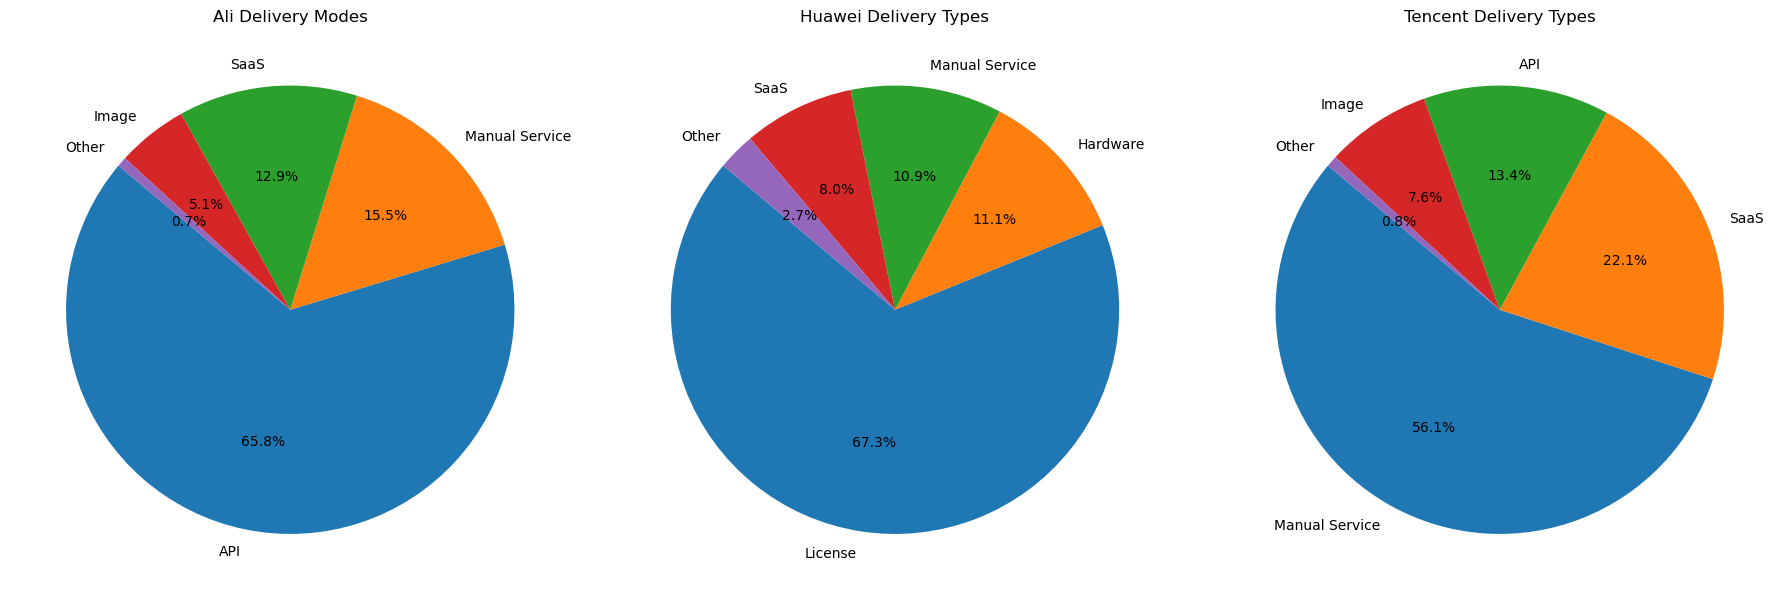

In [11]:
import matplotlib.pyplot as plt

# Data for each company
huawei_counts = [67.2, 11.1, 10.9, 8.0, 2.7]  # Huawei distribution percentages
huawei_labels = ["License", "Hardware", "Manual Service", "SaaS", "Other"]

tencent_counts = [56.1, 22.1, 13.4, 7.6, 0.8]  # Tencent distribution percentages
tencent_labels = ["Manual Service", "SaaS", "API", "Image", "Other"]

ali_counts = [65.8, 15.5, 12.9, 5.1, 0.7]  # Ali distribution percentages
ali_labels = ["API", "Manual Service", "SaaS", "Image", "Other"]

# Create a single figure with 3 subplots for the pie charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ali pie chart
axes[0].pie(ali_counts, labels=ali_labels, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Ali Delivery Modes')

# Huawei pie chart
axes[1].pie(huawei_counts, labels=huawei_labels, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Huawei Delivery Types')

# Tencent pie chart
axes[2].pie(tencent_counts, labels=tencent_labels, autopct='%1.1f%%', startangle=140)
axes[2].set_title('Tencent Delivery Types')



# Adjust layout for better spacing
plt.tight_layout()
plt.show()
